In [1]:
import math
import itertools
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
import scipy
import scipy.signal as sig
import RigolWFM.wfm as rigol
from reedmuller.reedmuller import ReedMuller
%matplotlib inline

Processing 24002 total samples
Processing 24002 total samples
Processing 24002 total samples
Processing 24002 total samples
Processing 24002 total samples
Processing 24002 total samples
Processing 24002 total samples
Processing 24002 total samples
Processing 24002 total samples
Processing 24002 total samples
Processing 24002 total samples
Processing 24002 total samples


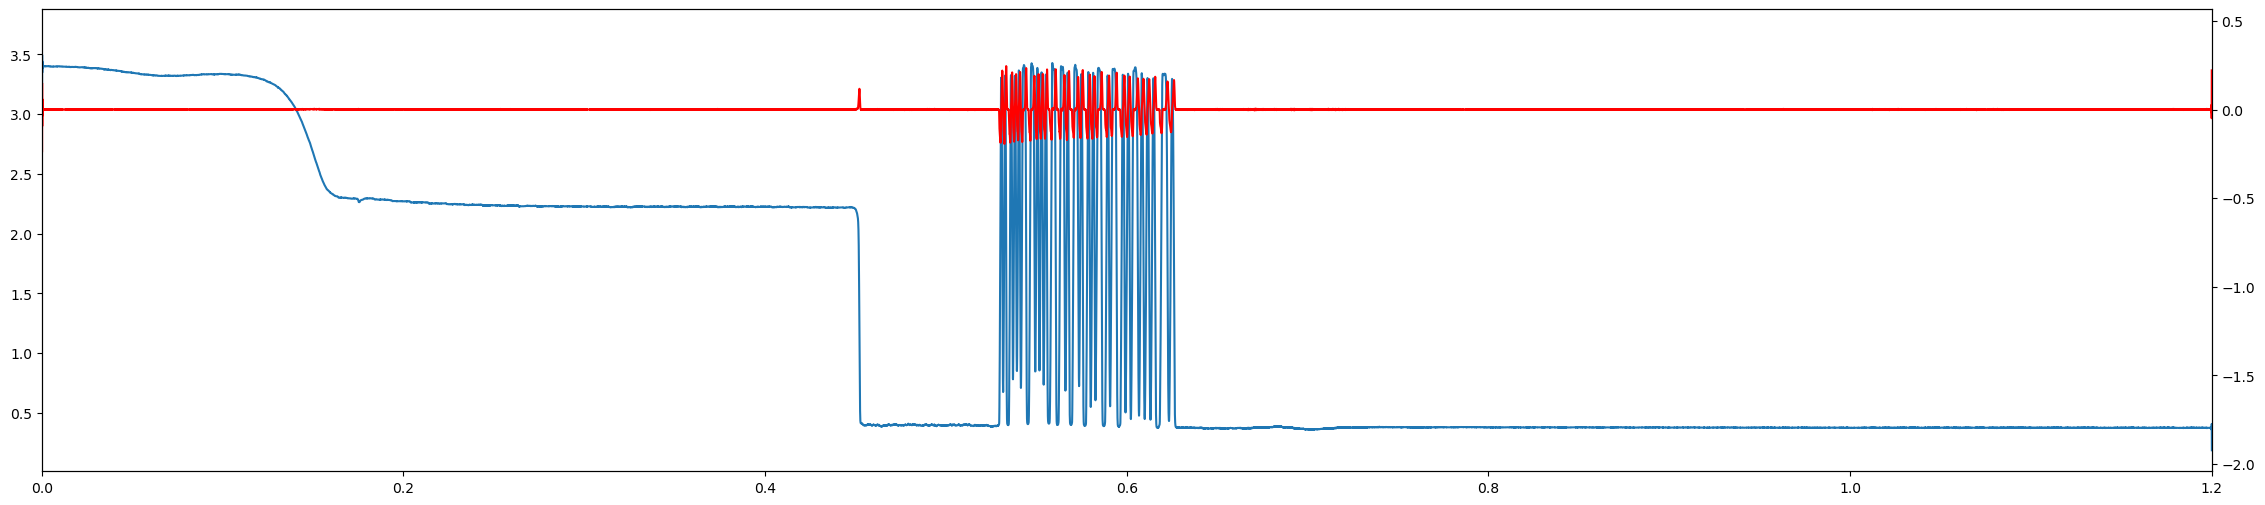

In [2]:
#wf = rigol.Wfm.from_file('barcode_test_varspeed.wfm', 'DS1054Z')
# Initial test with waveforms/manchester/manchester_rm_1234567_04.wfm
wfs = []
for f in Path('waveforms/manchester/').glob('manchester_rm_*.wfm'):
    wf = rigol.Wfm.from_file(str(f), 'DS1054Z')
    data = wf.channels[0].volts
    
    downsampling = 500
    data = scipy.signal.decimate(data, downsampling, ftype='fir')[::-1]
    td = wf.channels[0].seconds_per_point * downsampling
    times = np.linspace(0, len(data)*td, len(data))
    
    print(f'Processing {len(data)} total samples')
    wfs.append((td, times, data))

fig, ax = plt.subplots(figsize=(28, 6))
ax.plot(times, data)
ax.set_xlim([times[0], times[-1]])

deltas = data[:-1] - data[1:]
ax.twinx().plot(times[:-1], deltas, color='red')

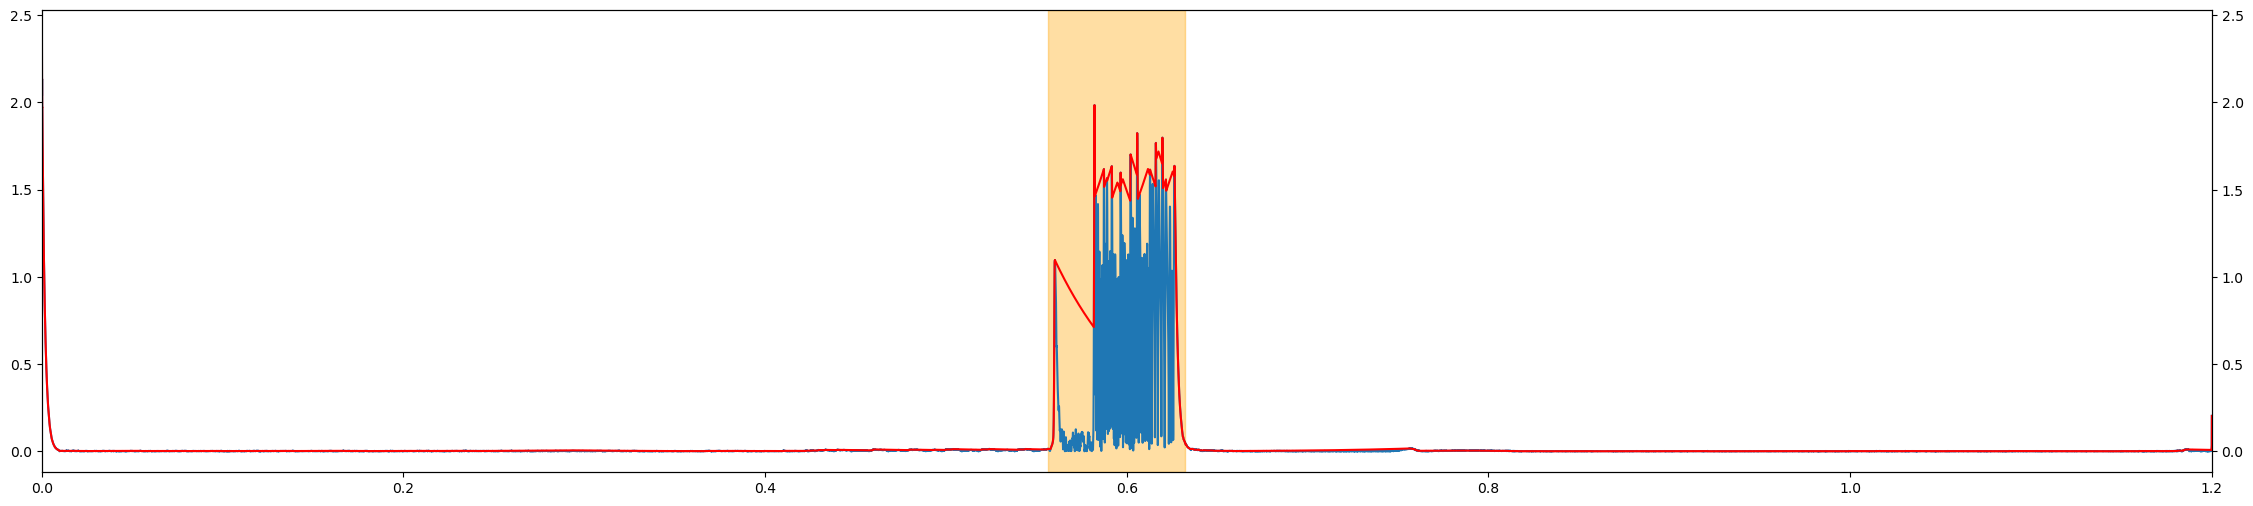

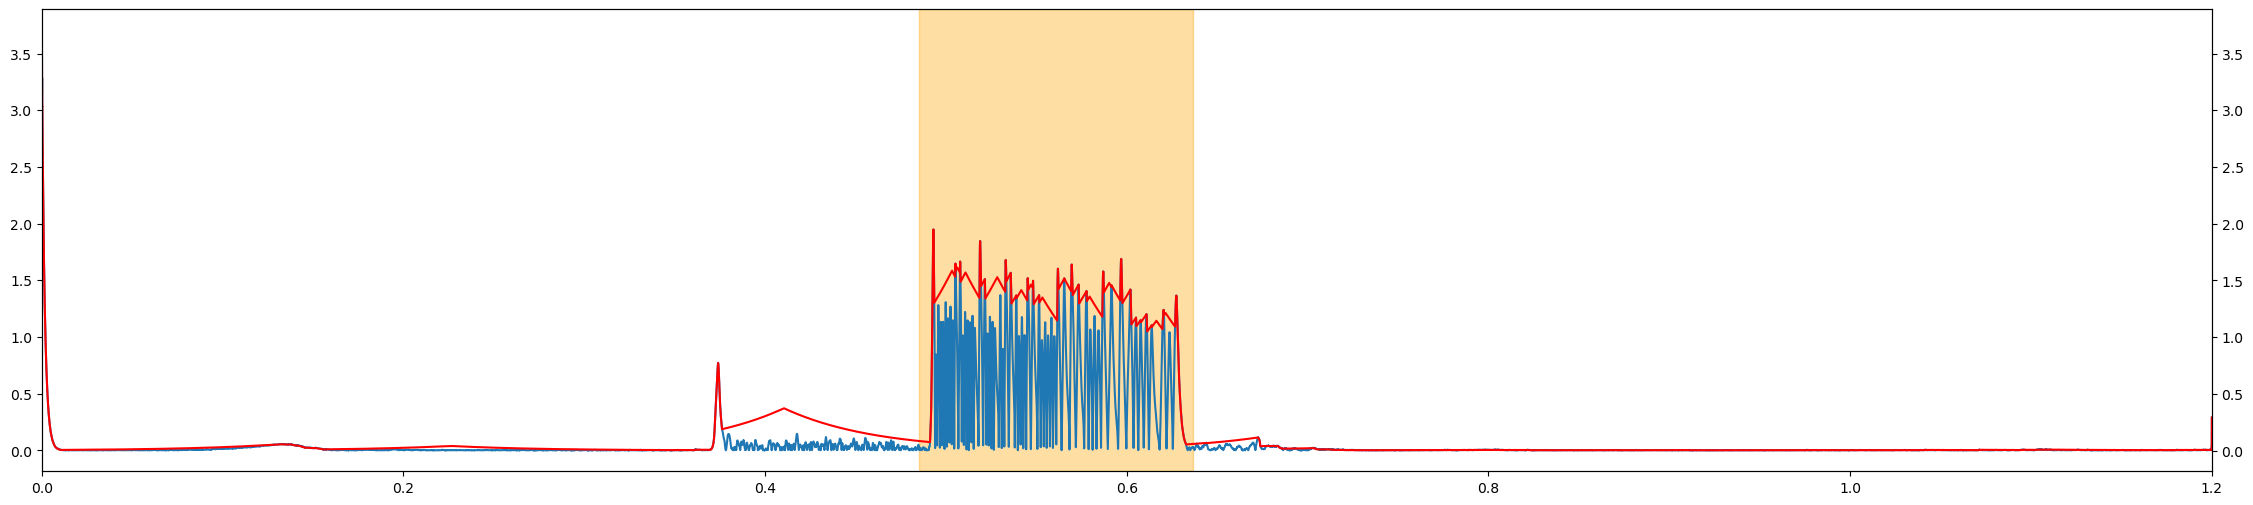

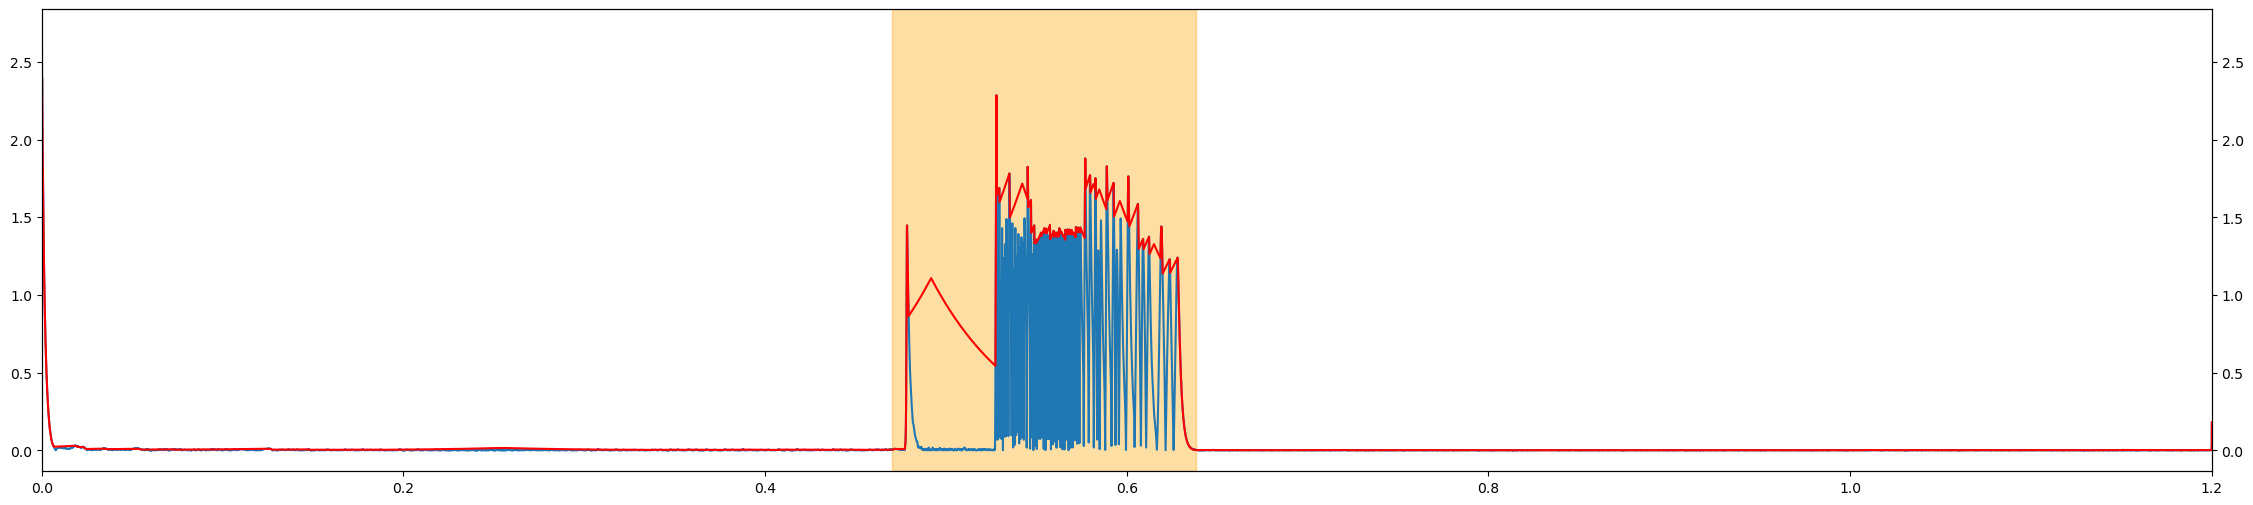

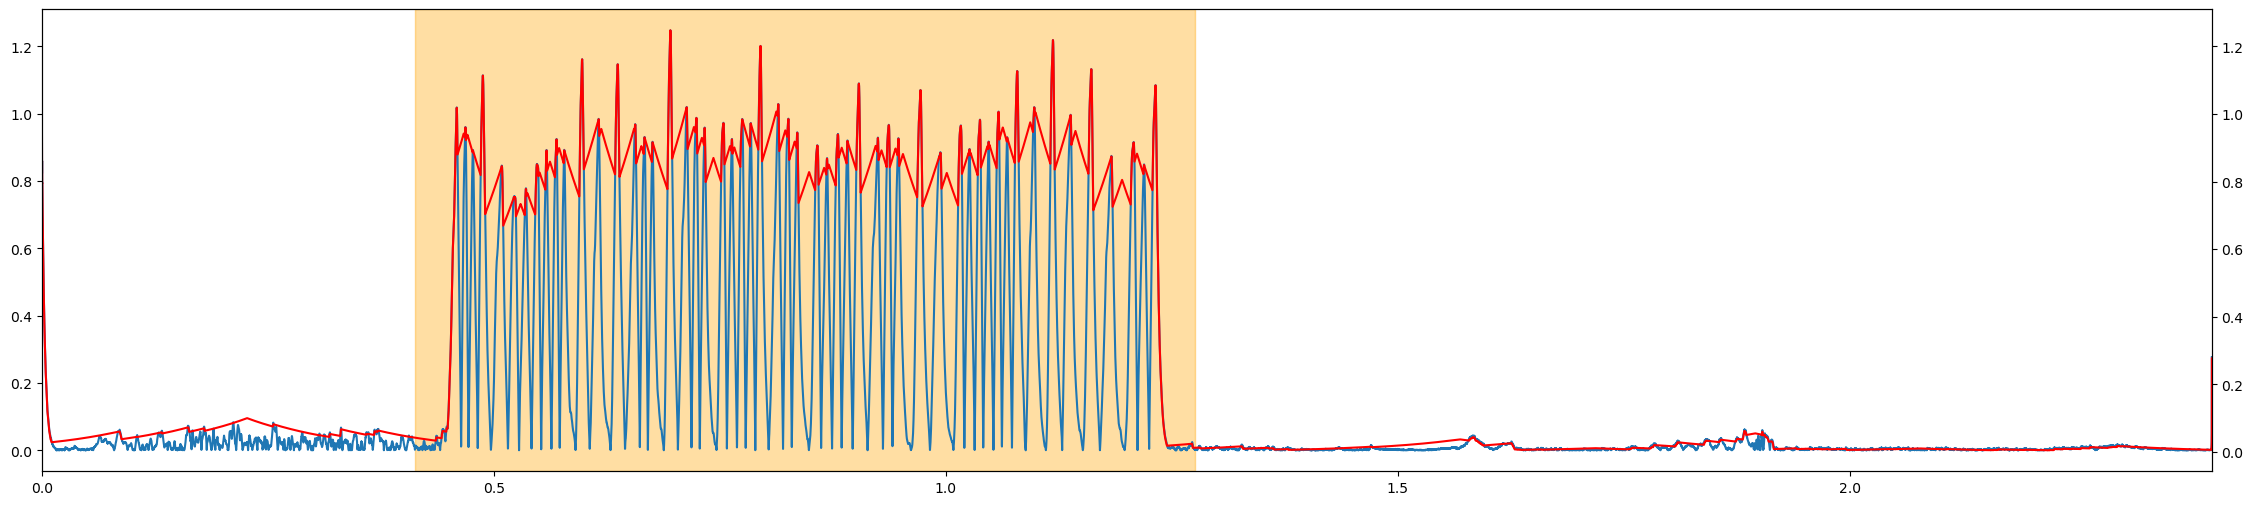

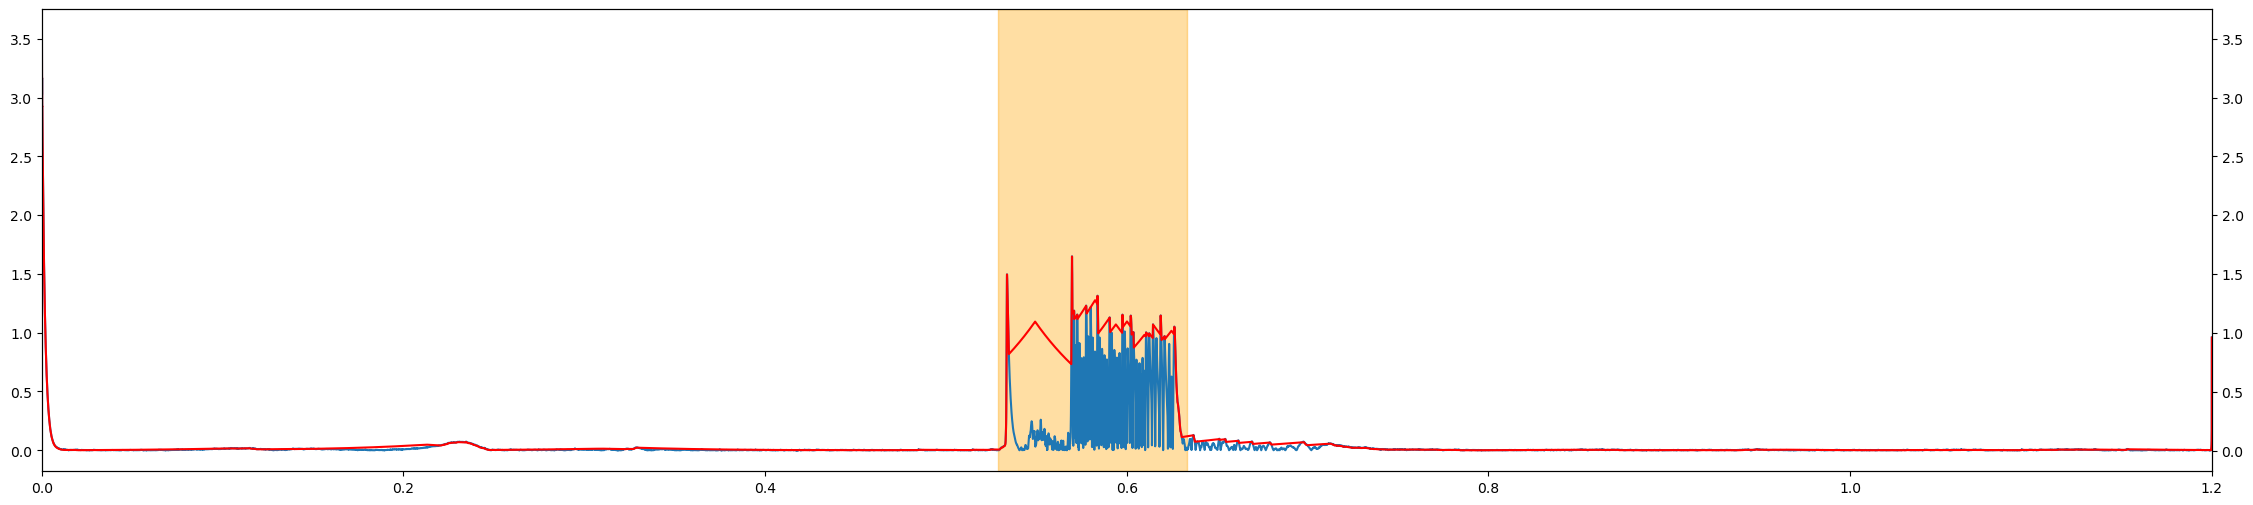

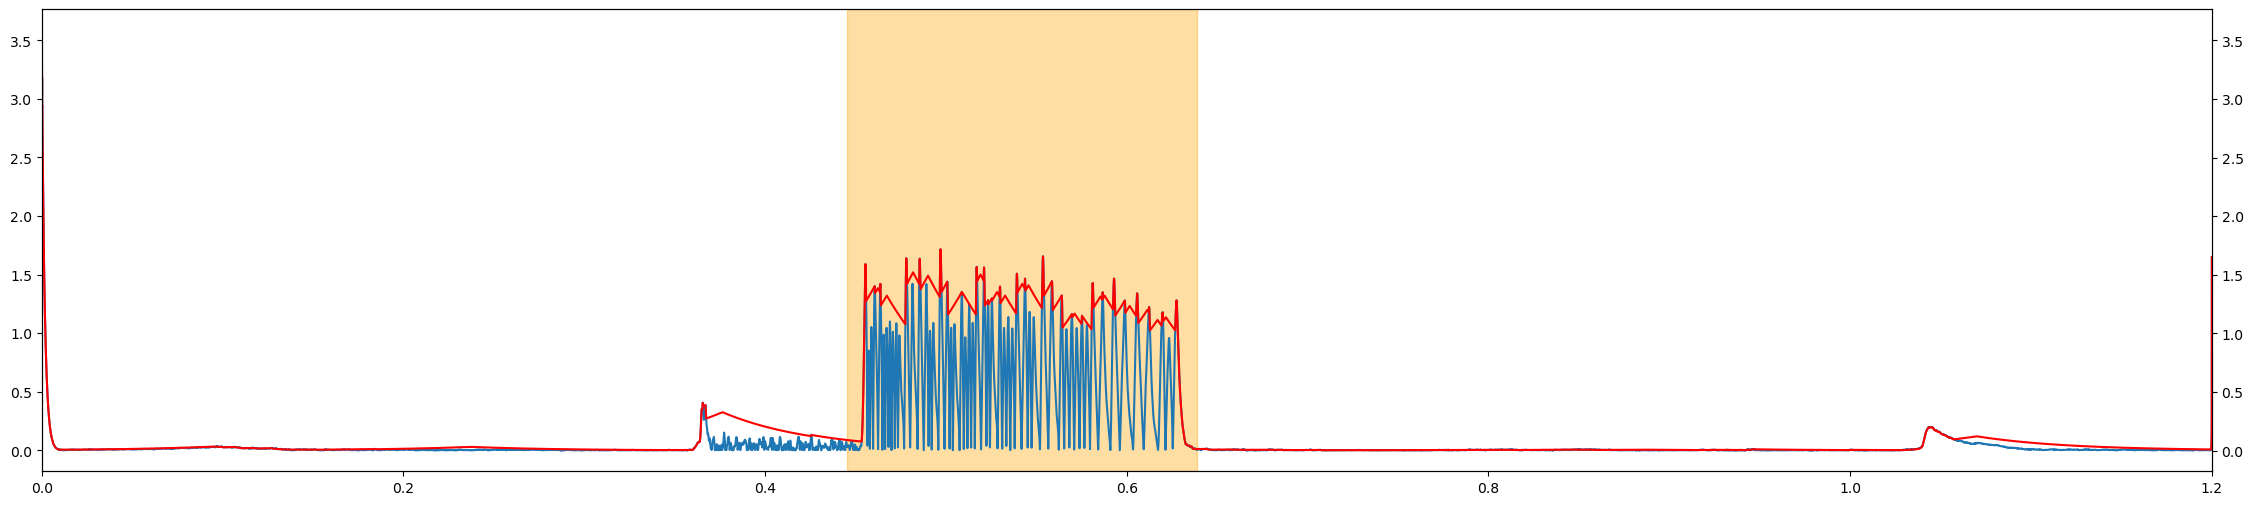

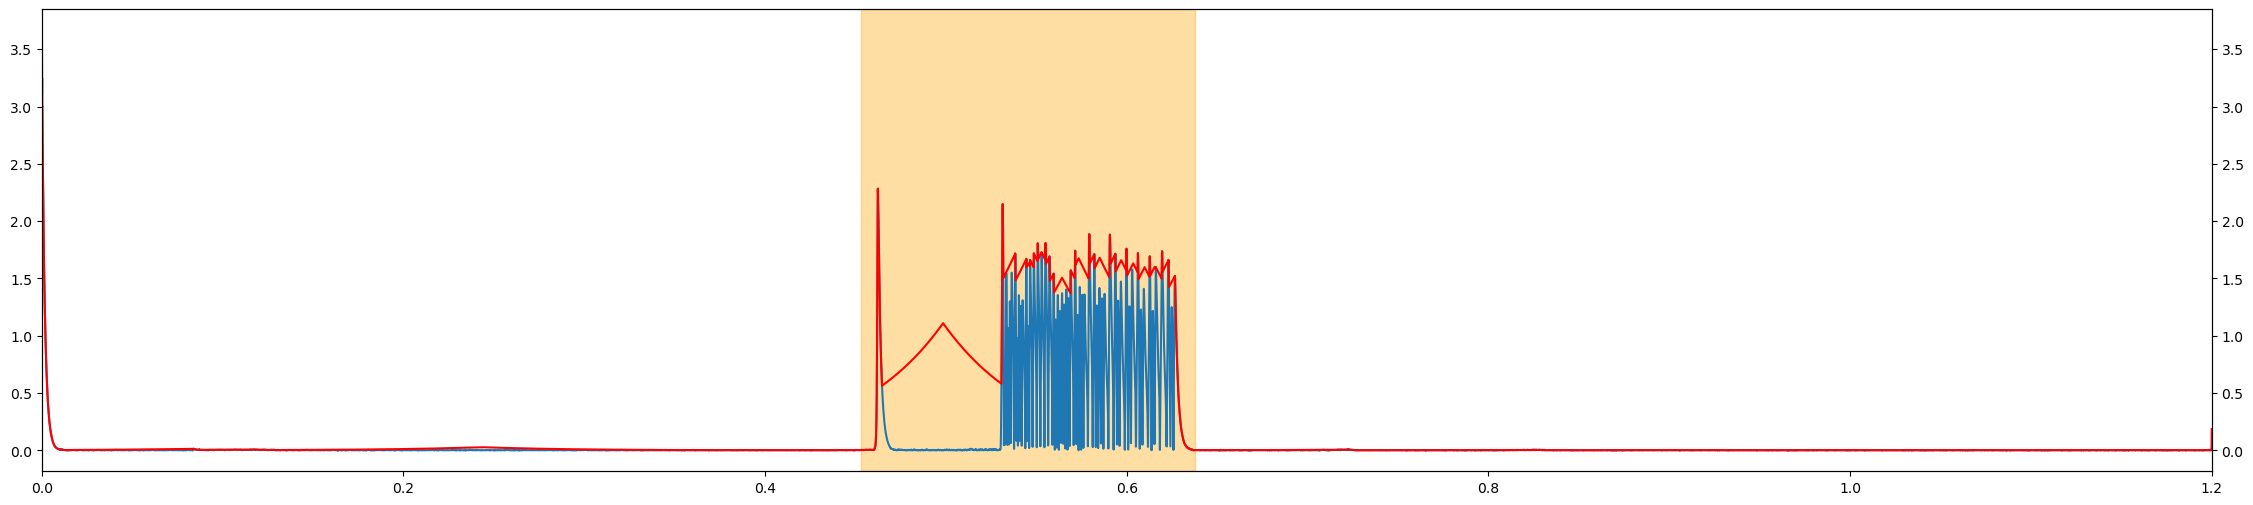

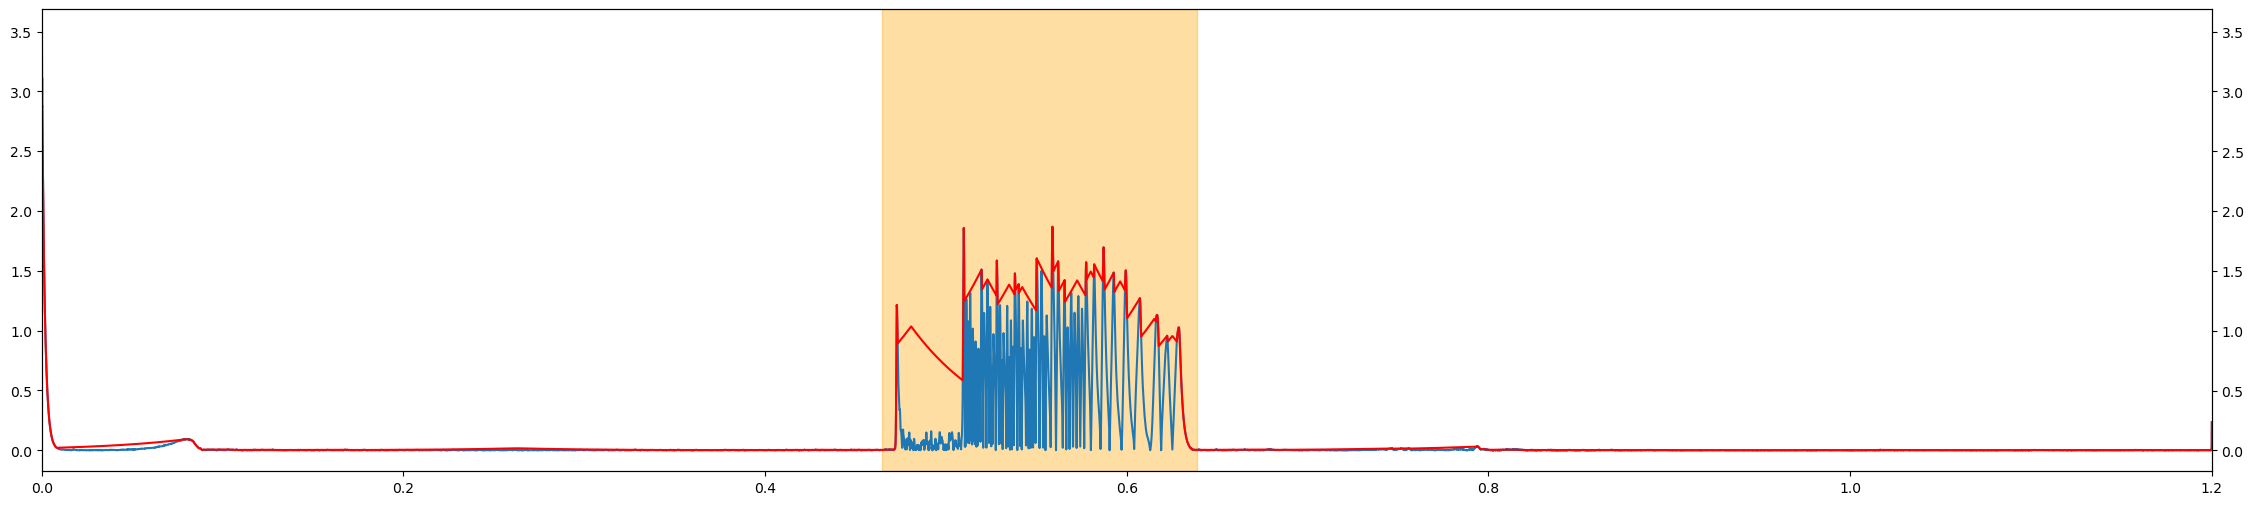

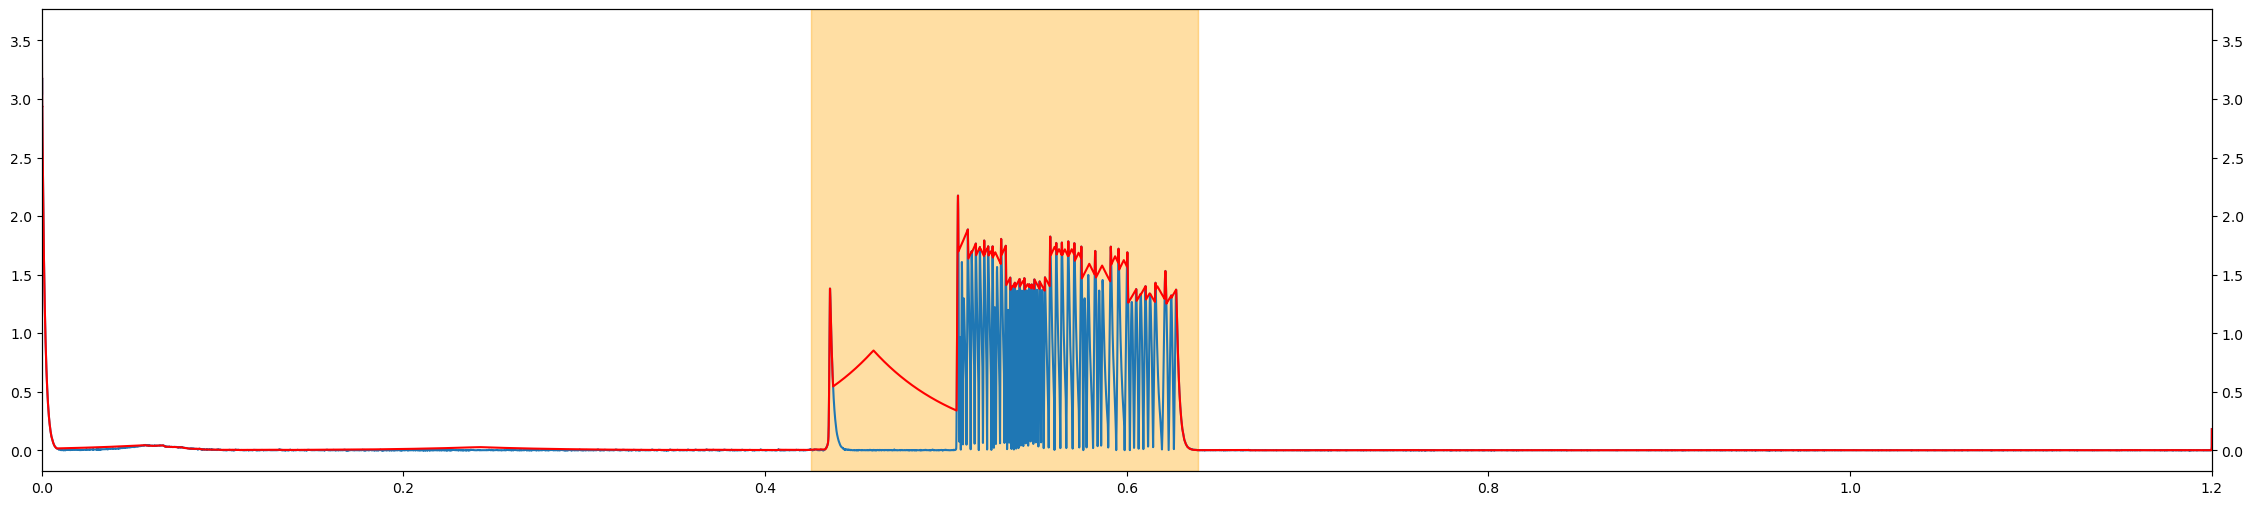

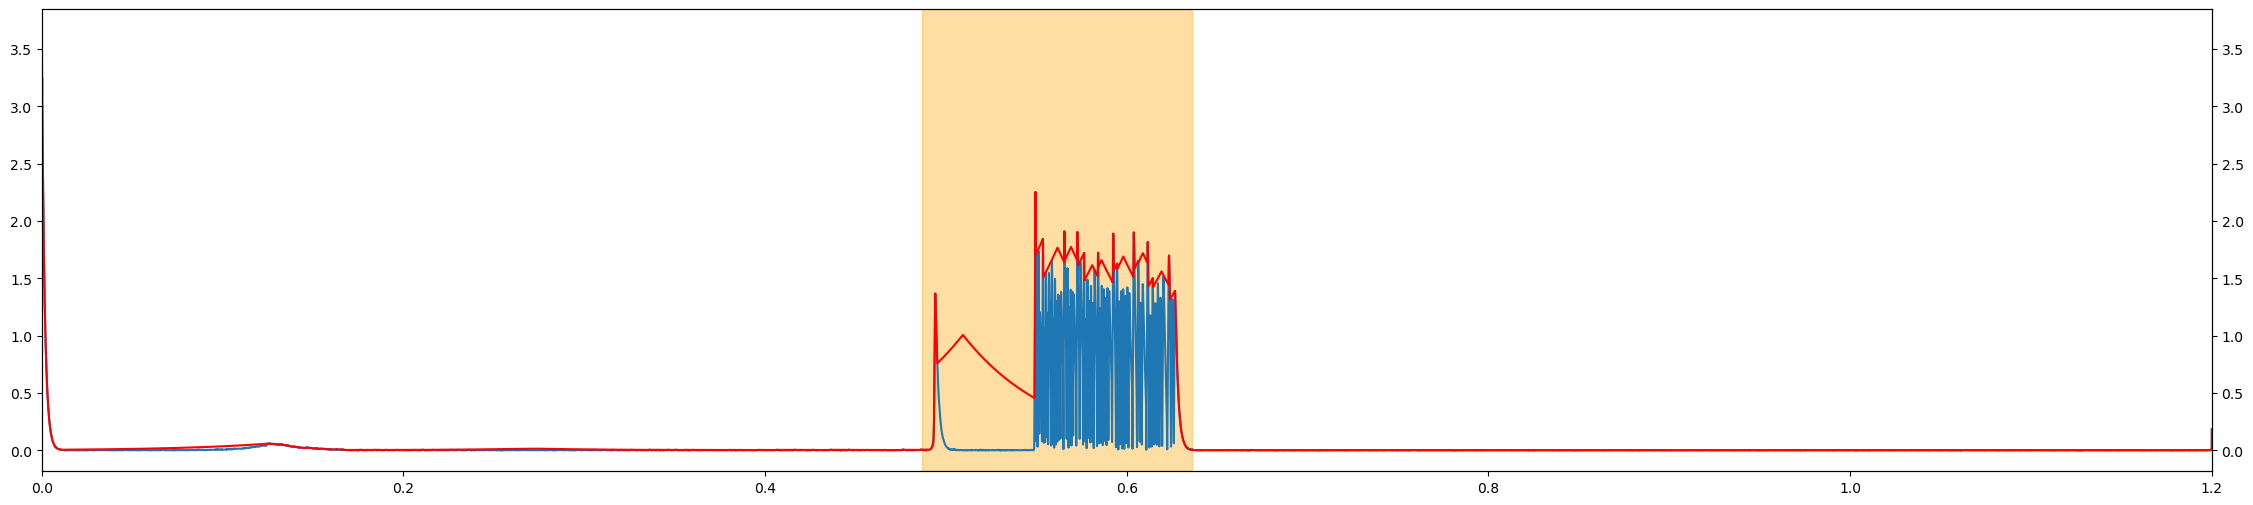

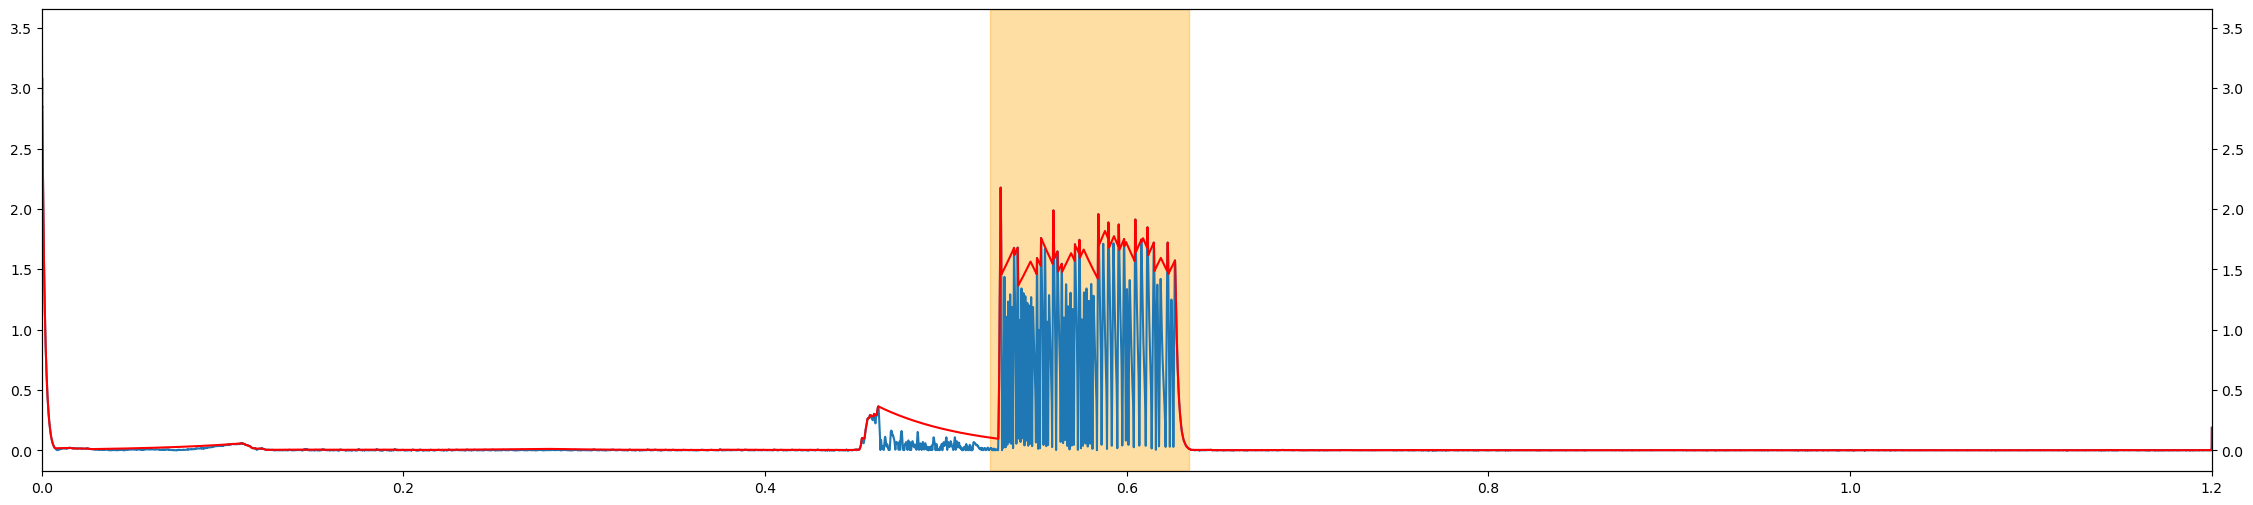

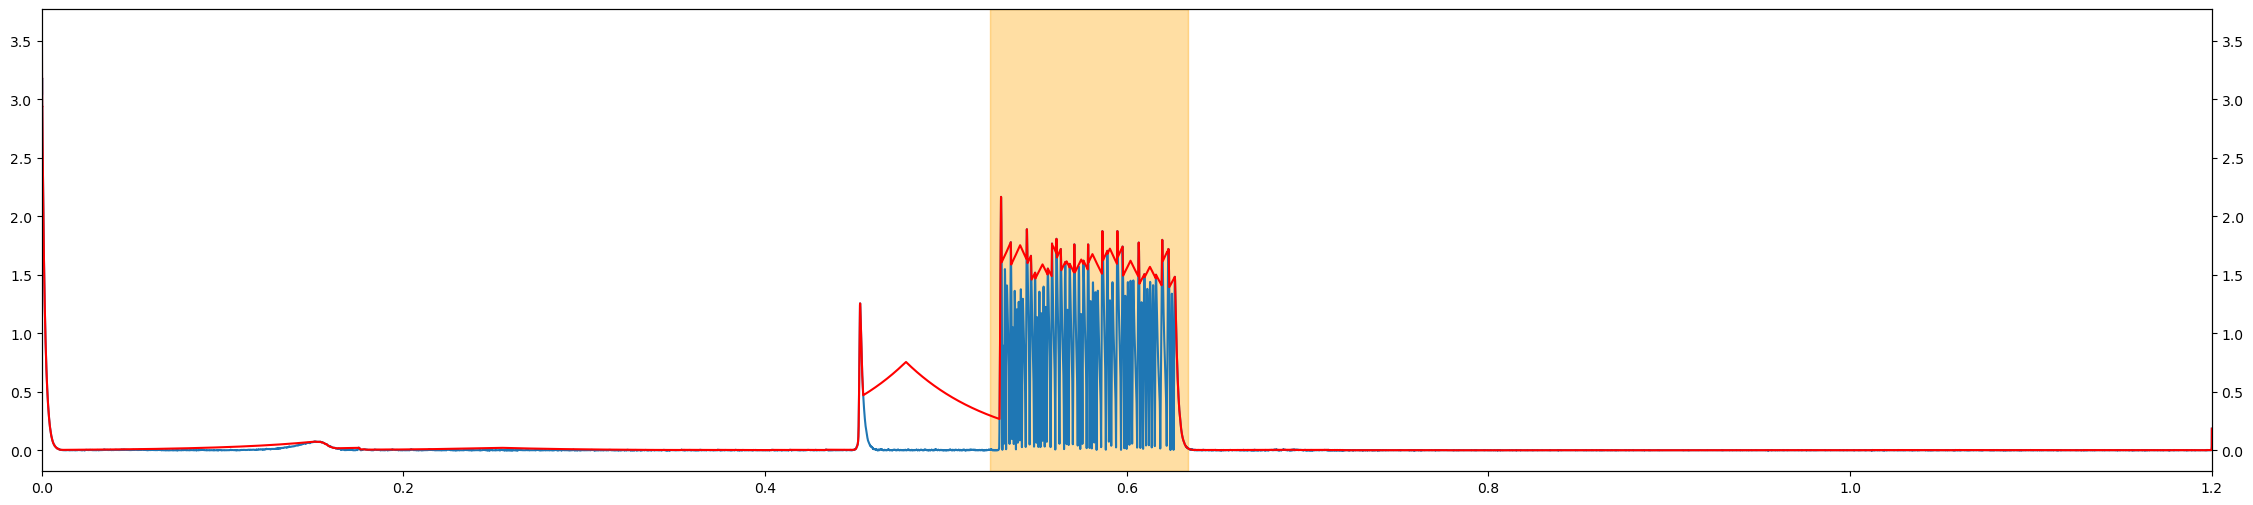

In [3]:
def find_signal(td, times, data):
    sos = sig.butter(1, 50, 'highpass', output='sos', fs=10e3)
    jitter = np.abs(sig.sosfilt(sos, data))
    
    def sweep(ys, coeff=0.999):
        out = np.zeros(ys.shape)
        acc = 0
        for i, y in enumerate(ys):
            if y > acc:
                acc = y
            else:
                acc *= coeff
            out[i] = acc
        return out
    
    loc = np.min(np.vstack([sweep(jitter), sweep(jitter[::-1])[::-1]]), axis=0)
    
    loc_th = 0.333
    sel = (loc > loc_th).astype(int)
    indices = np.squeeze(np.argwhere(sel[1:] - sel[:-1]))
    if sel[0]:
        indices = indices[1:]
    
    fig, ax = plt.subplots(figsize=(28, 6))
    ax.plot(times, jitter)
    ax.twinx().plot(times, loc, color='red')
    ax.set_xlim([times[0], times[-1]])
    
    largest_interval = 0.02 # Min interval length
    found_a, found_b = None, None
    for a, b in zip(indices[0::2], indices[1::2]):
        dt = times[b] - times[a]
        if dt < 1.5 and dt > largest_interval:
            largest_interval = dt
            d_idx = b - a
            guard = 0.05
            found_a, found_b = round(a - d_idx*guard), round(b + d_idx*guard)
    
    ax.axvspan(times[found_a], times[found_b], color='orange', alpha=.2, zorder=-3)
    for a, b in zip(indices[0::2], indices[1::2]):
        dt = times[b] - times[a]
        if dt < 1.5 and dt > largest_interval:
            largest_interval = dt
            d_idx = b - a
            guard = 0.05
            found_a, found_b = round(a - d_idx*guard), round(b + d_idx*guard)
    
    ax.axvspan(times[found_a], times[found_b], color='orange', alpha=.2, zorder=-3)
    return found_a, found_b

found_signals = [find_signal(*wf) for wf in wfs]

[(11048, 13972), (9629, 13752), (9343, 13659), (4075, 13049), (10516, 13525), (8839, 13655), (8990, 13824), (9234, 13488), (8442, 13697), (9657, 13884), (10409, 13918), (10417, 13926)]


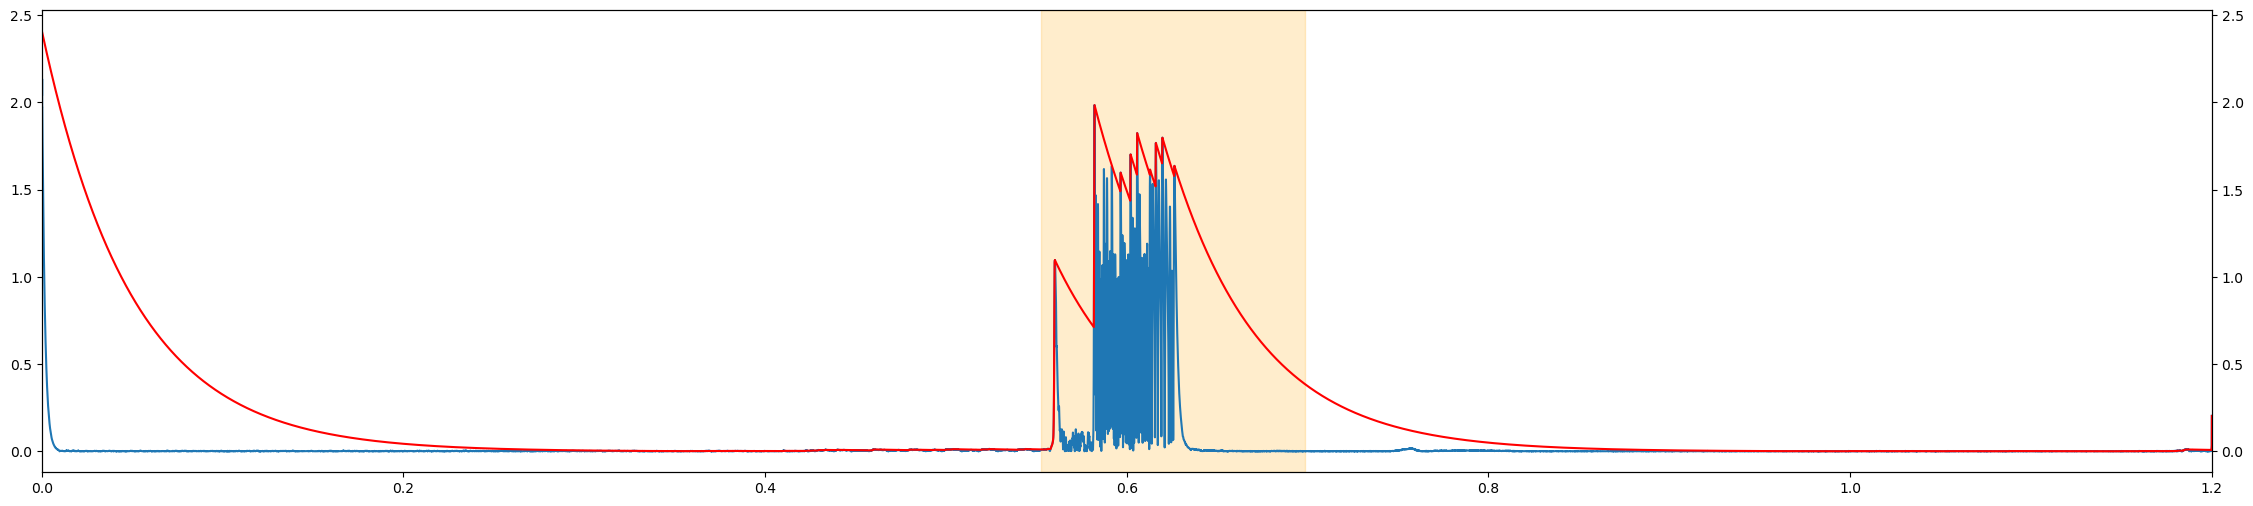

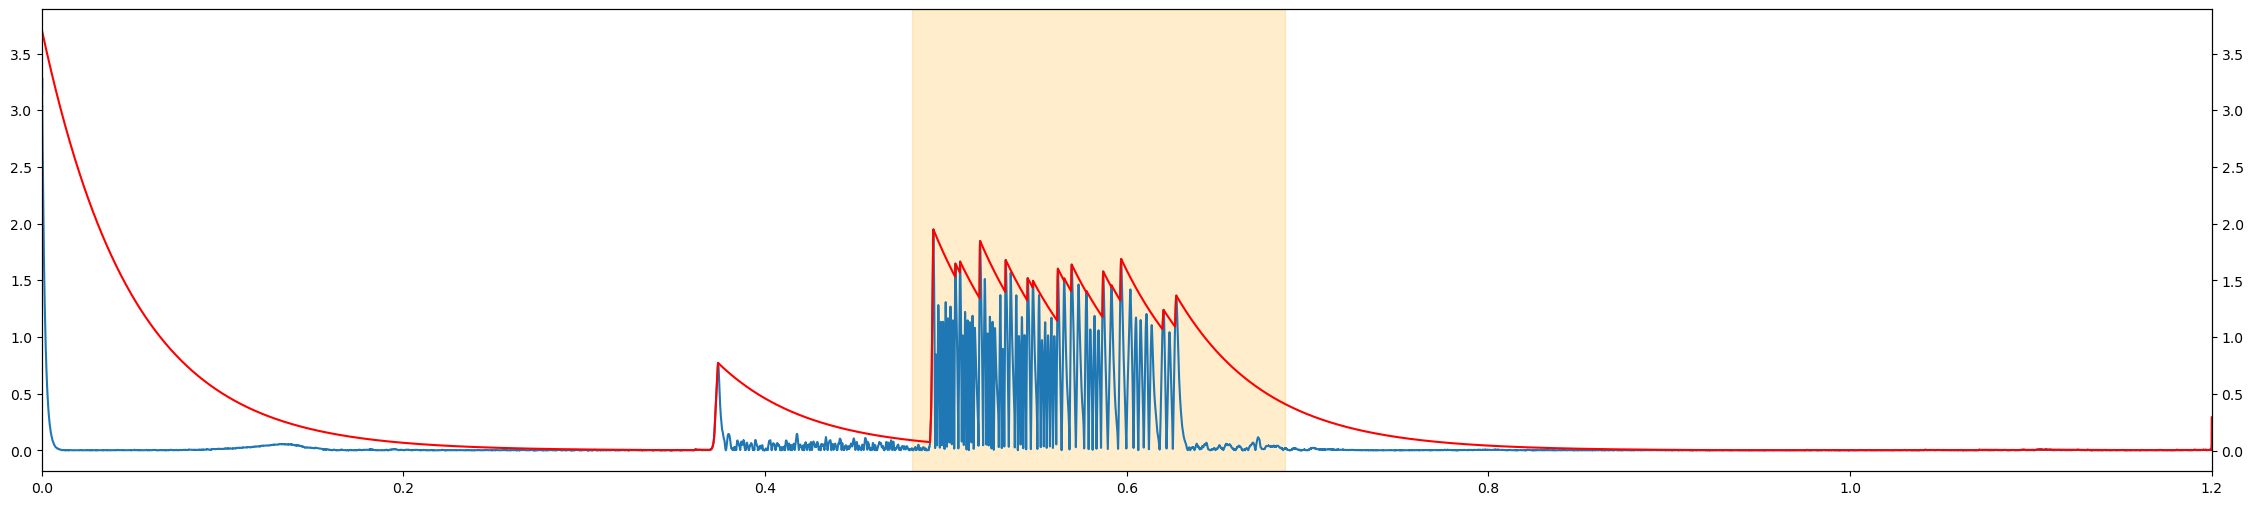

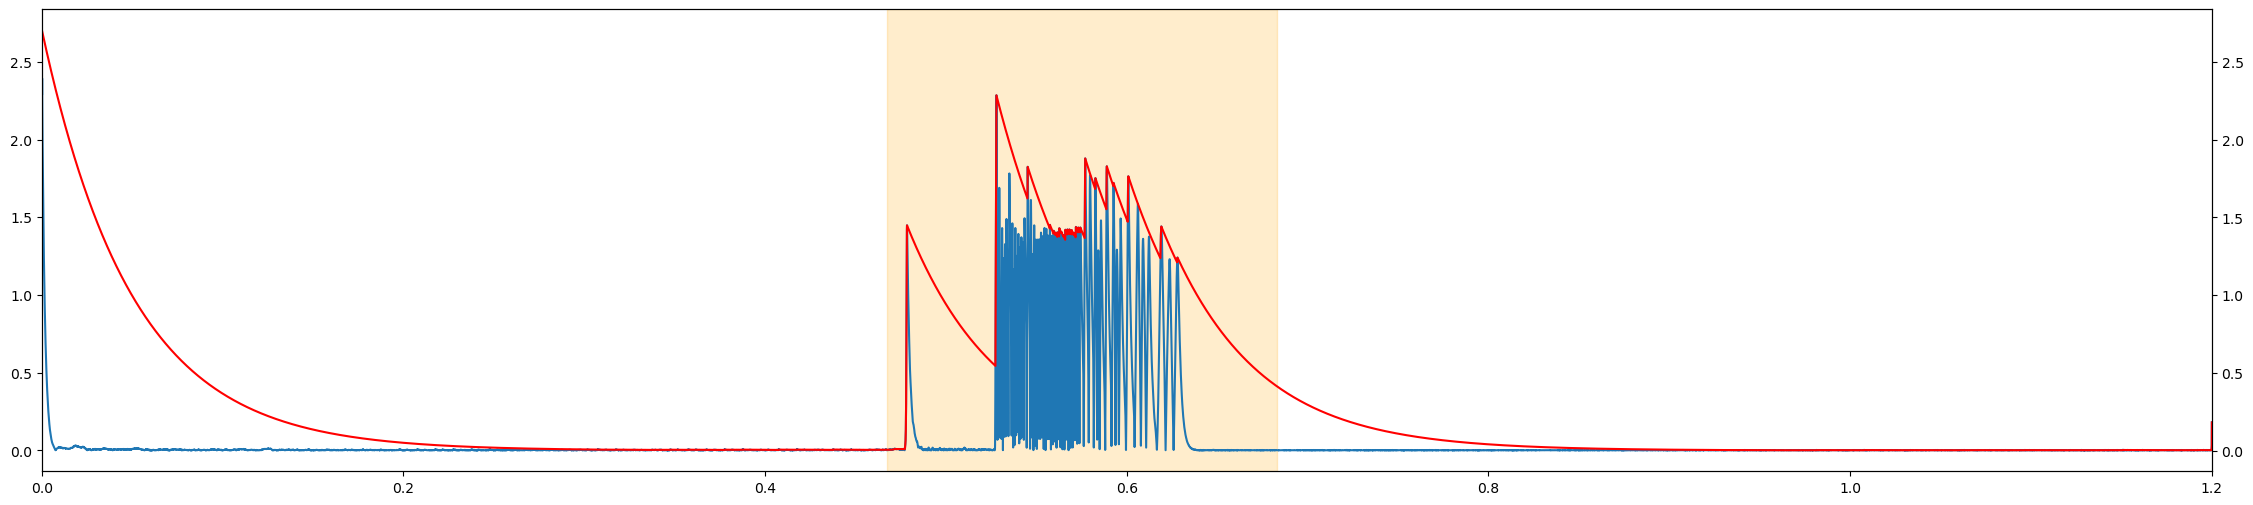

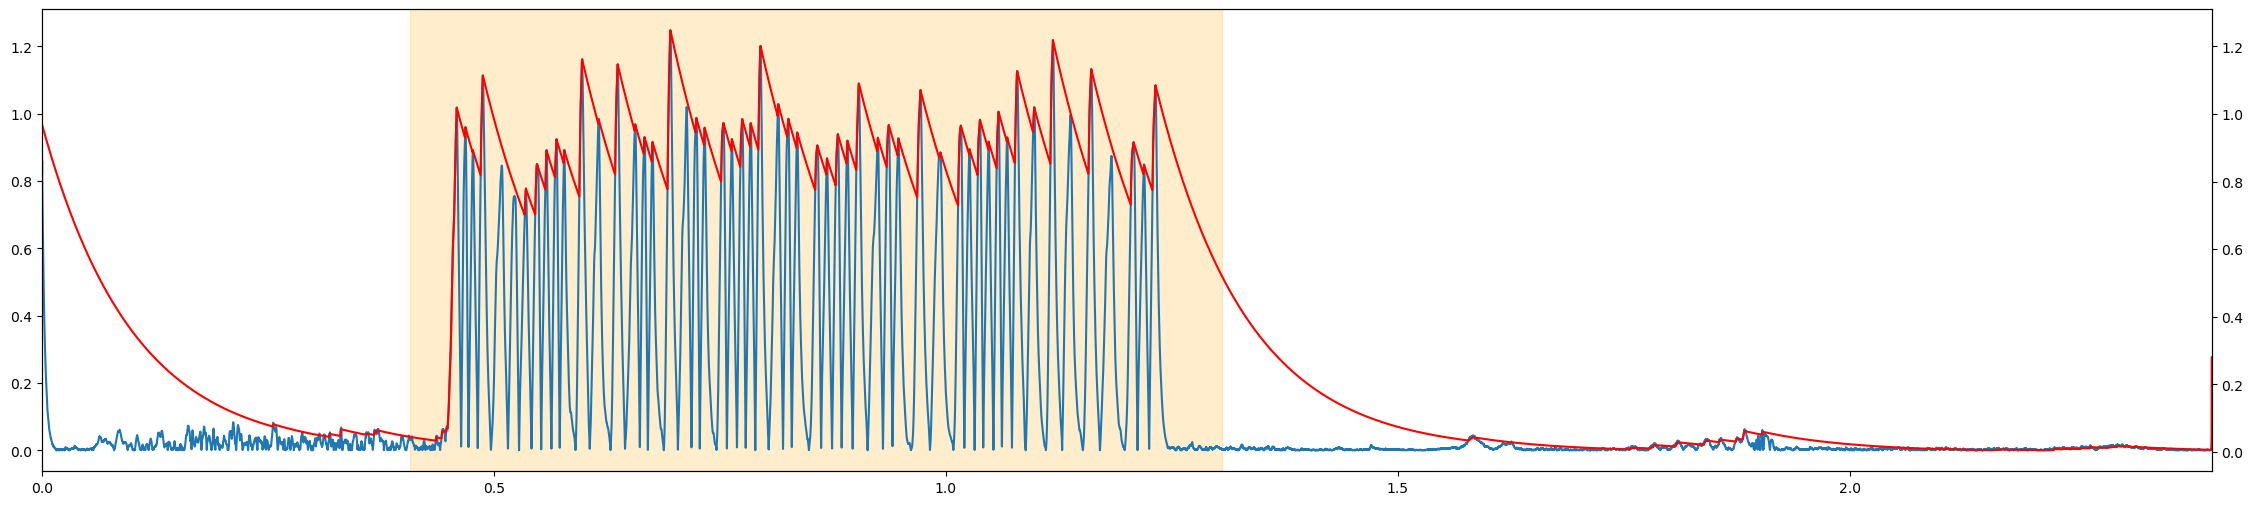

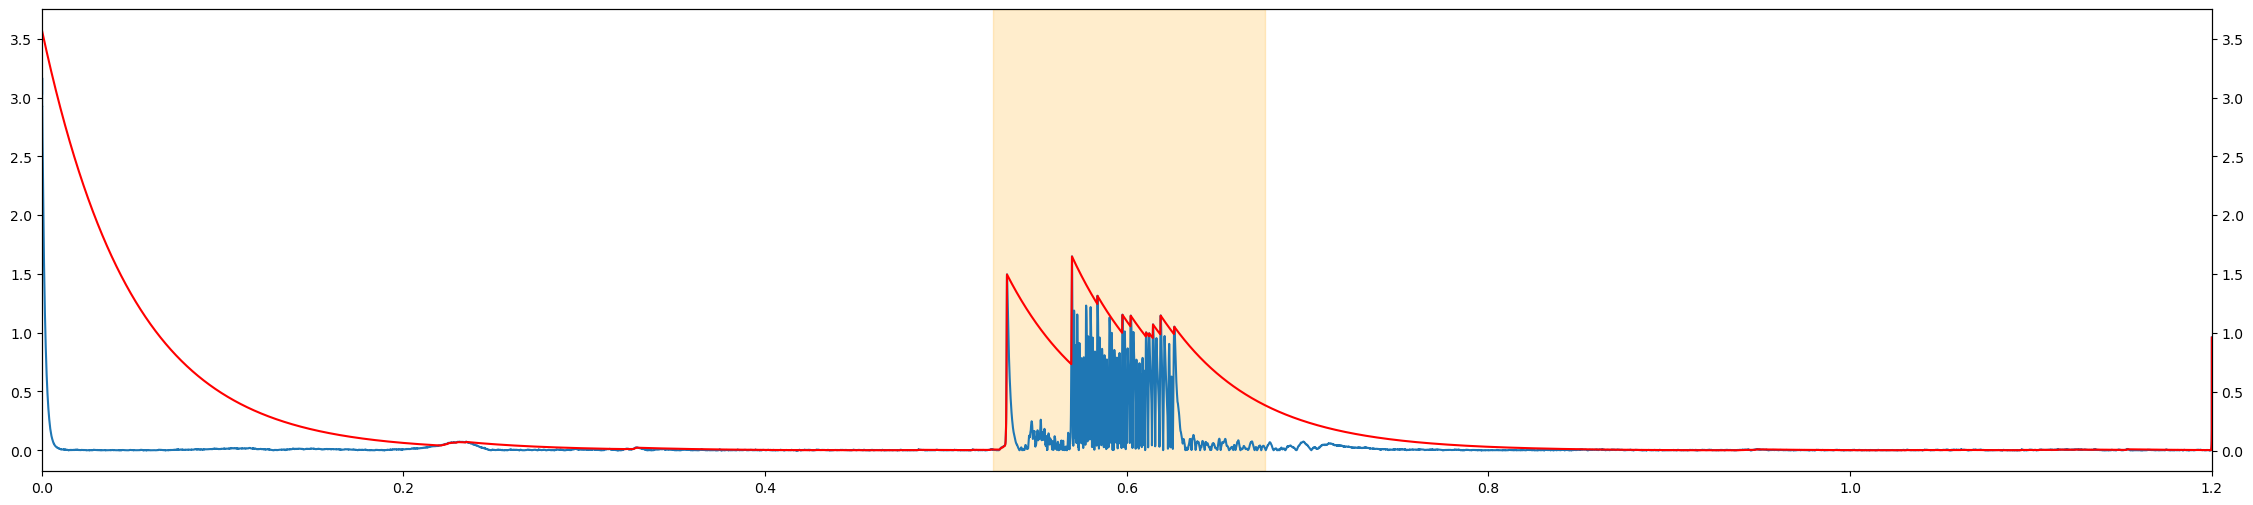

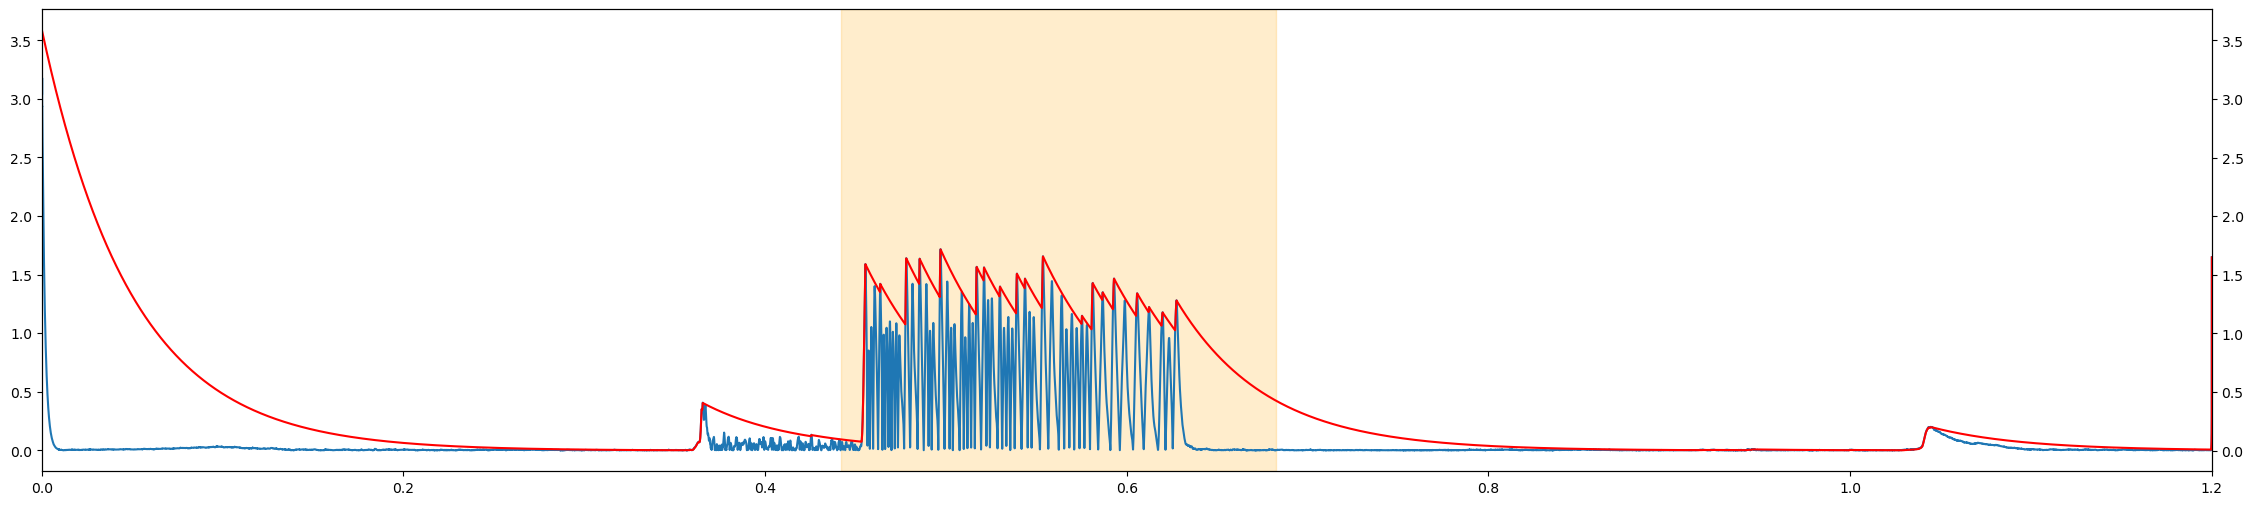

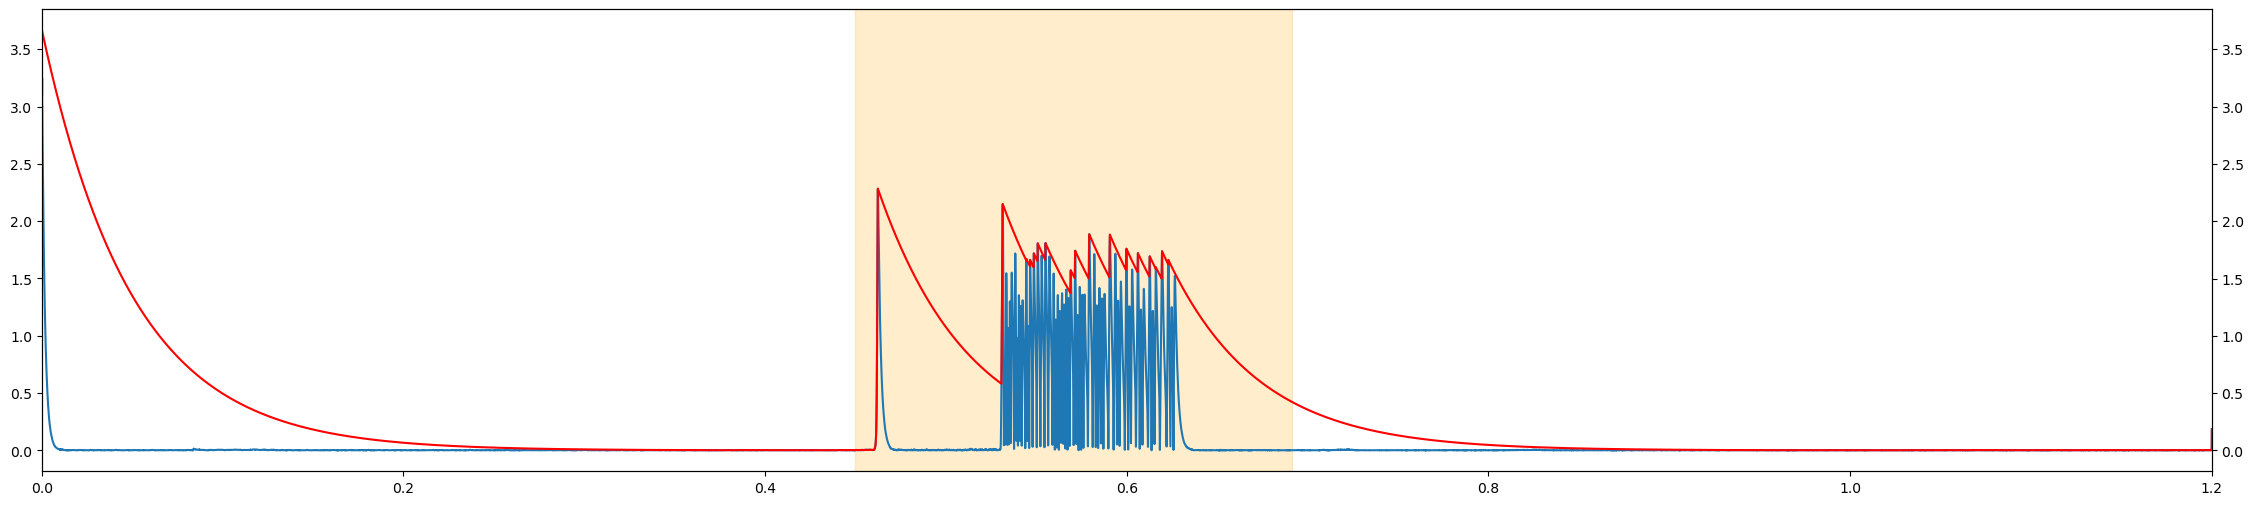

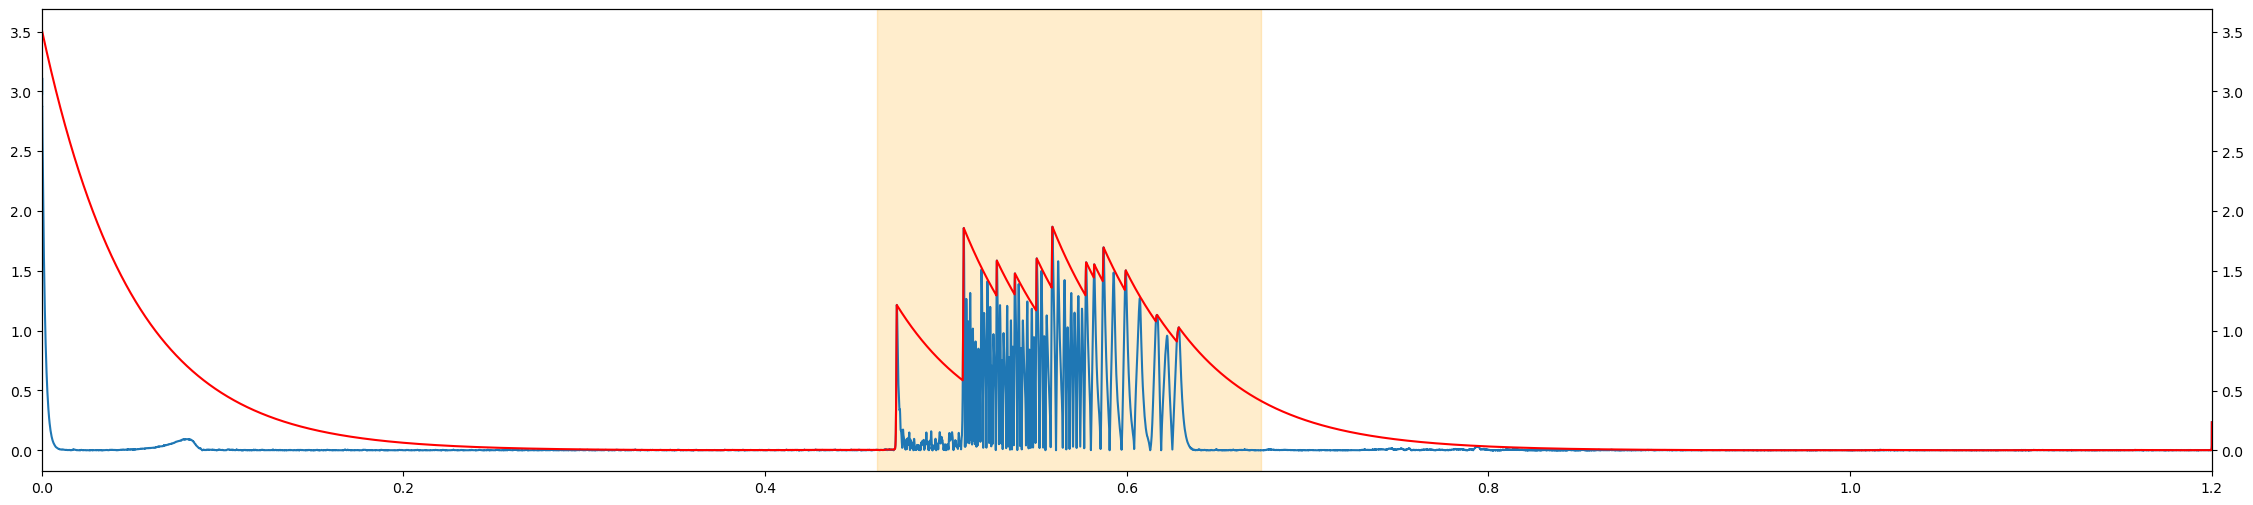

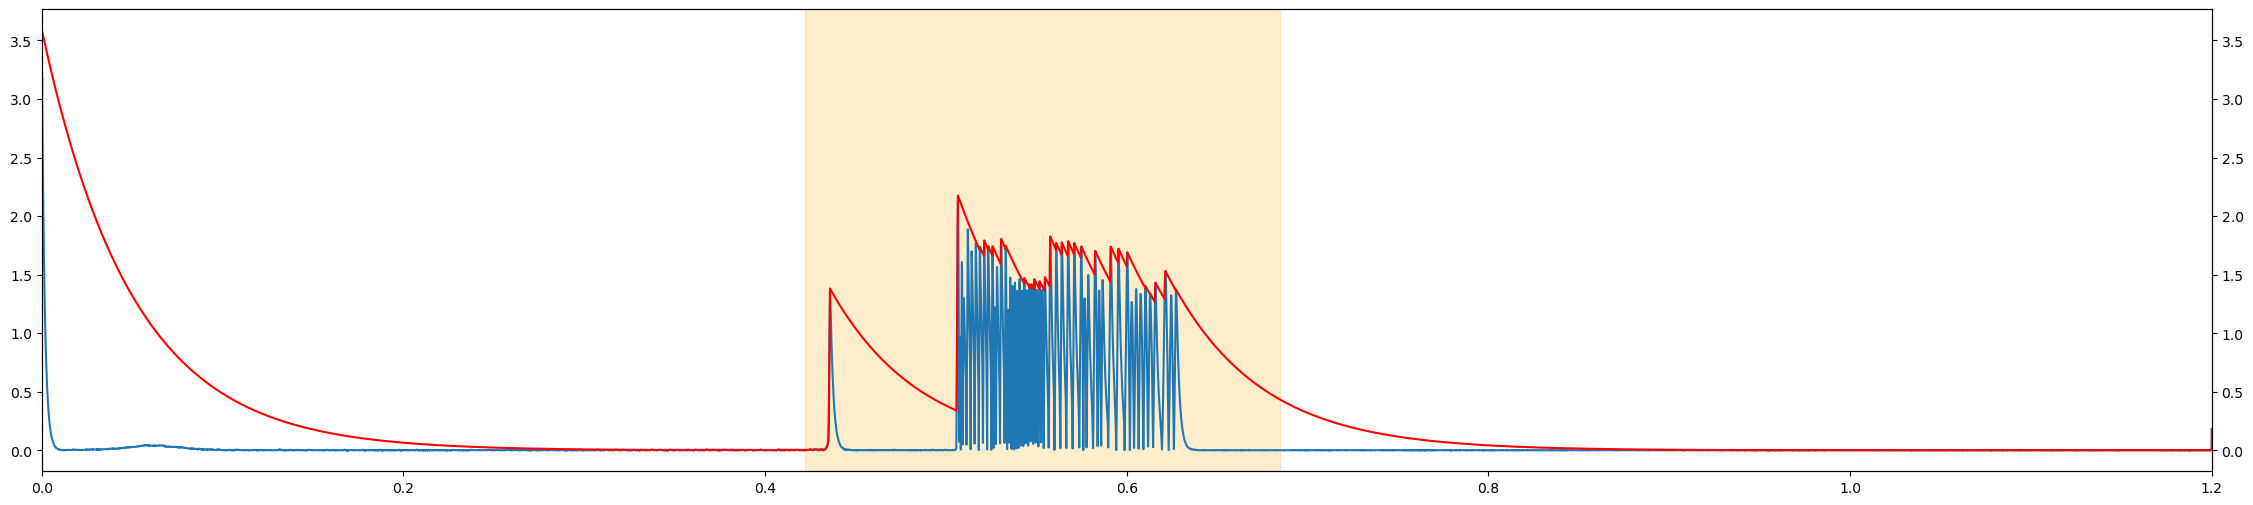

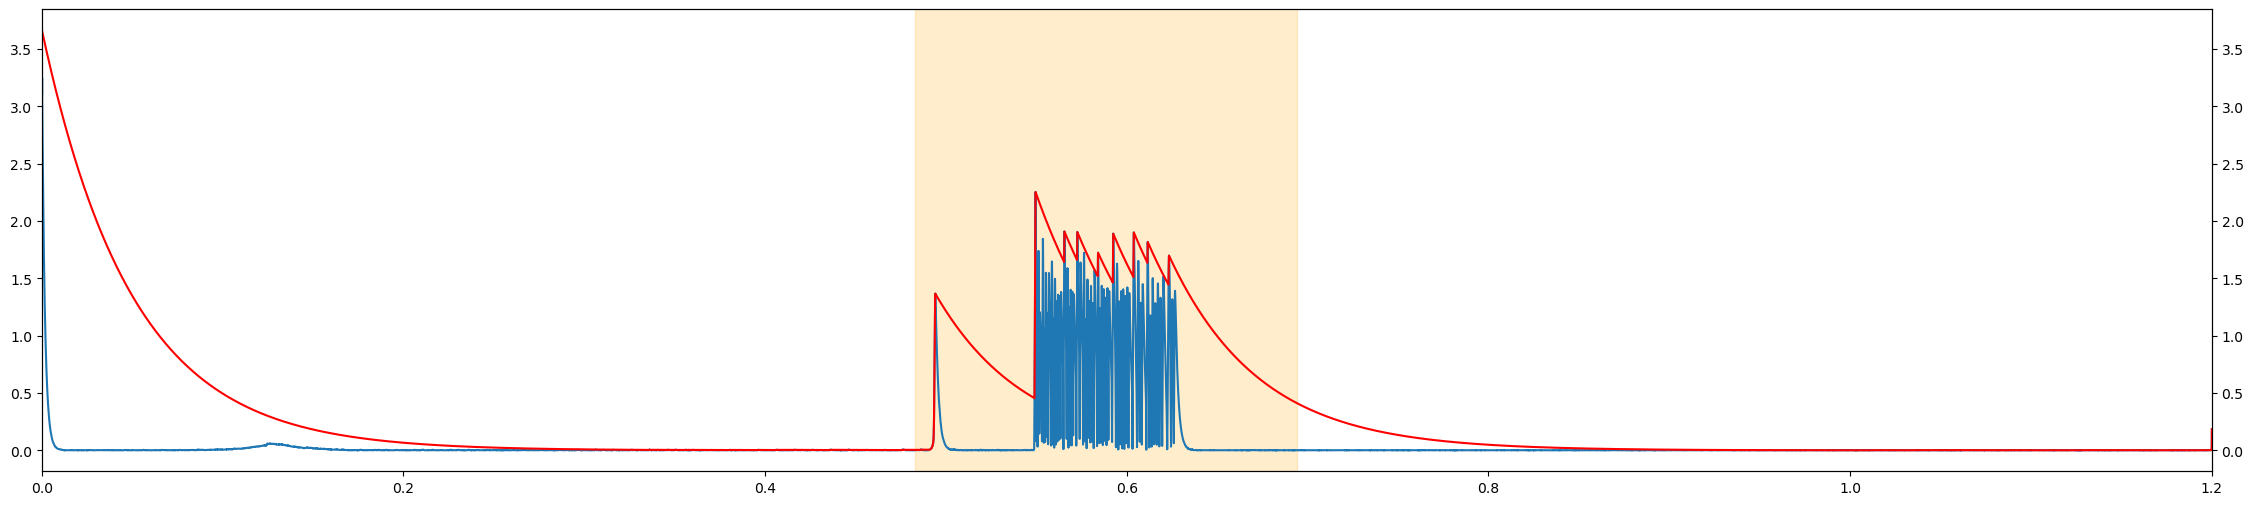

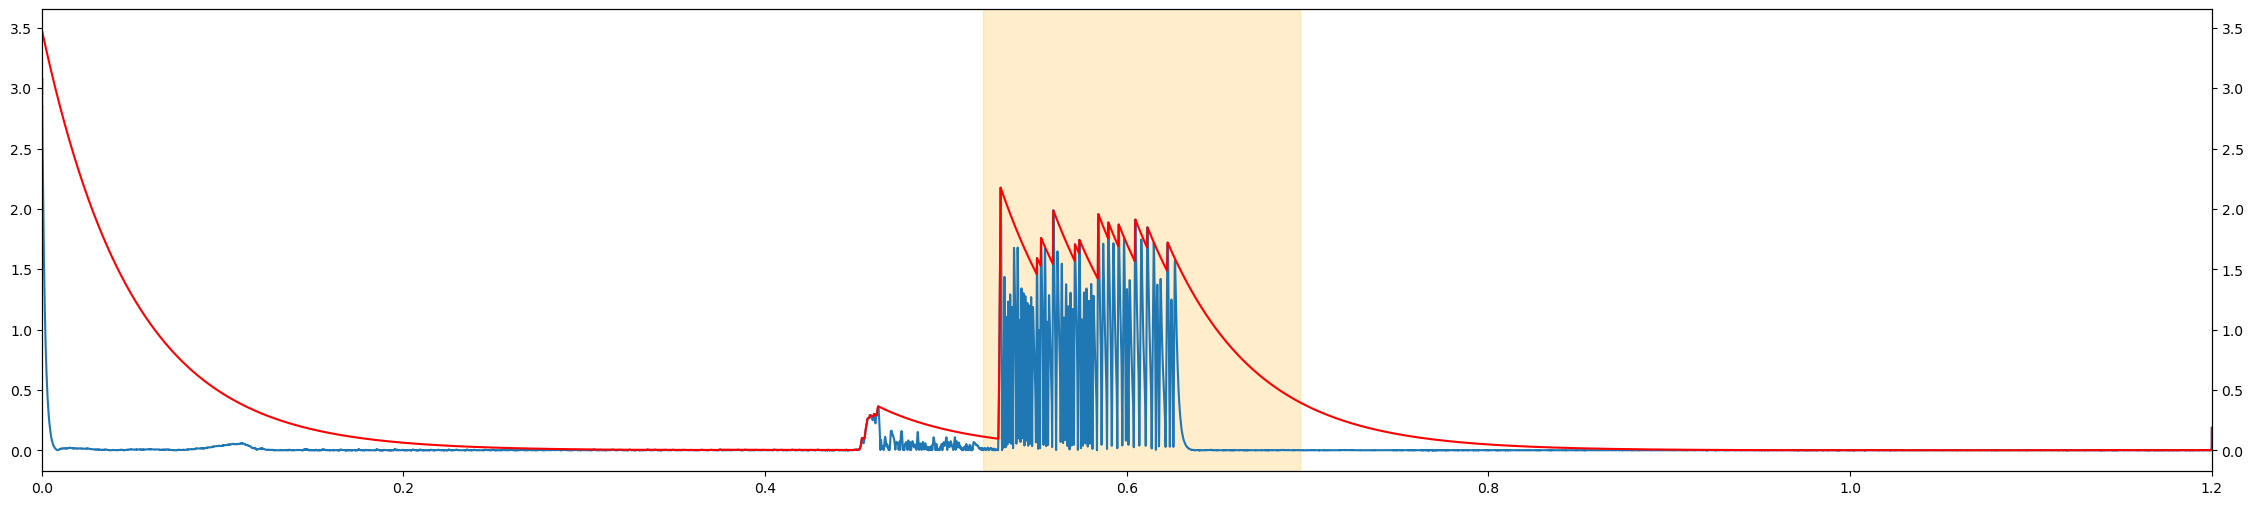

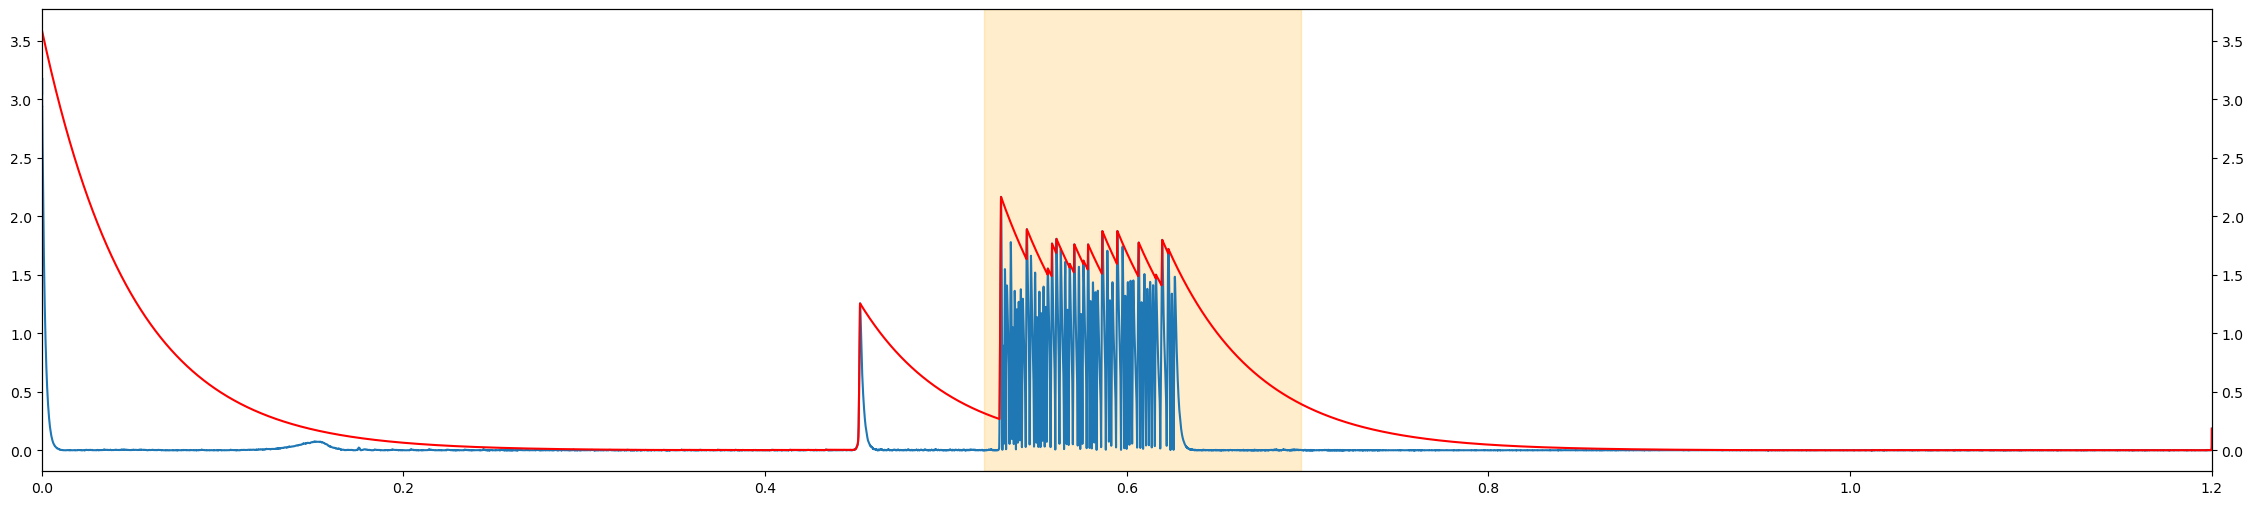

In [11]:
def find_signal(td, times, data):
    sos = sig.butter(1, 50, 'highpass', output='sos', fs=10e3)
    jitter = np.abs(sig.sosfilt(sos, data))
    
    def sweep(ys, coeff=0.999):
        out = np.zeros(ys.shape)
        acc = 0
        for i, y in enumerate(ys):
            if y > acc:
                acc = y
            else:
                acc *= coeff
            out[i] = acc
        return out
    
    loc = sweep(jitter)
    
    loc_th = 0.333
    sel = (loc > loc_th).astype(int)
    indices = np.squeeze(np.argwhere(sel[1:] - sel[:-1]))
    if sel[0]:
        indices = indices[1:]
    
    fig, ax = plt.subplots(figsize=(28, 6))
    ax.plot(times, jitter)
    ax.twinx().plot(times, loc, color='red')
    ax.set_xlim([times[0], times[-1]])
    
    largest_interval = 0.02 # Min interval length
    found_a, found_b = None, None
    for a, b in zip(indices[0::2], indices[1::2]):
        dt = times[b] - times[a]
        if dt < 1.5 and dt > largest_interval:
            largest_interval = dt
            d_idx = b - a
            guard_left, guard_right = 0.05, -0.05
            found_a, found_b = round(a - d_idx*guard_left), round(b + d_idx*guard_right)
    
    ax.axvspan(times[found_a], times[found_b], color='orange', alpha=.2, zorder=-3)
    return found_a, found_b

found_signals = [find_signal(*wf) for wf in wfs]
print(found_signals)

adjusting edges Framing error
101100110110110110011001101100110110110110011011011011001101100110110110011001100110011011

adjusting edges Framing error
101101100110011001011011011001101101101100110110110011011011011001100110110110011001100110011011

adjusting edges Edges ok, found 64 manchester bits
Resulting payload length: 32 bits
Payload: 11011111011111111111111010010010
Resuling data word: 2aaaaaa
1010101001101010101001101010101010101010101010101001100101100101100101101

adjusting edges Framing error
101100110110110110011001101100110011011010010110110011001100110011011010101010101

adjusting edges Framing error
10101011011011001100110110011011011011001101101101100110110011011011011001100110011011

adjusting edges Framing error
101100110110110110011001101100110110110110010110110110010110011011011011001100110011011

adjusting edges Edges ok, found 64 manchester bits
Resulting payload length: 32 bits
Payload: 10001101010111110001000100110011
Resuling data word: 1111111
101010010101101

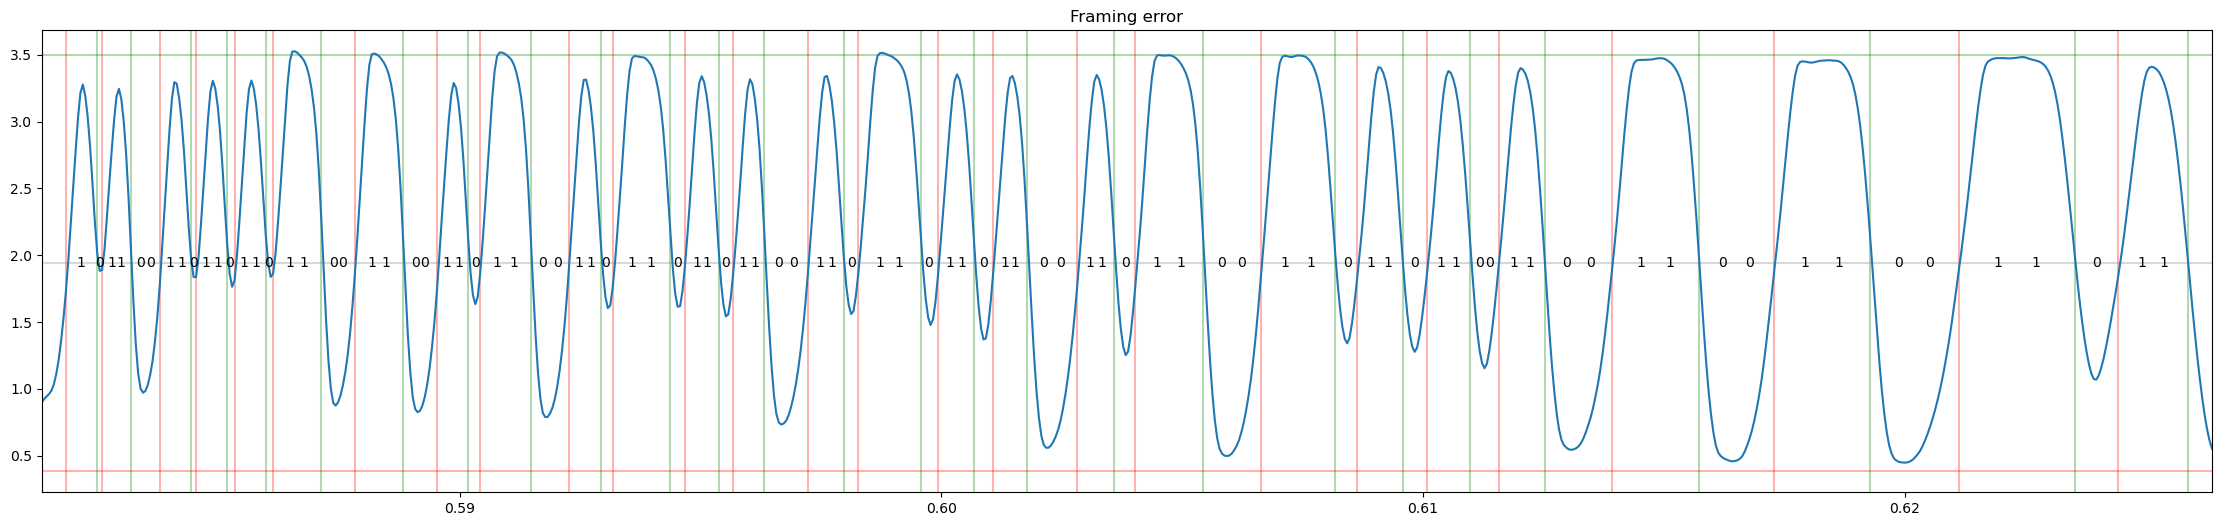

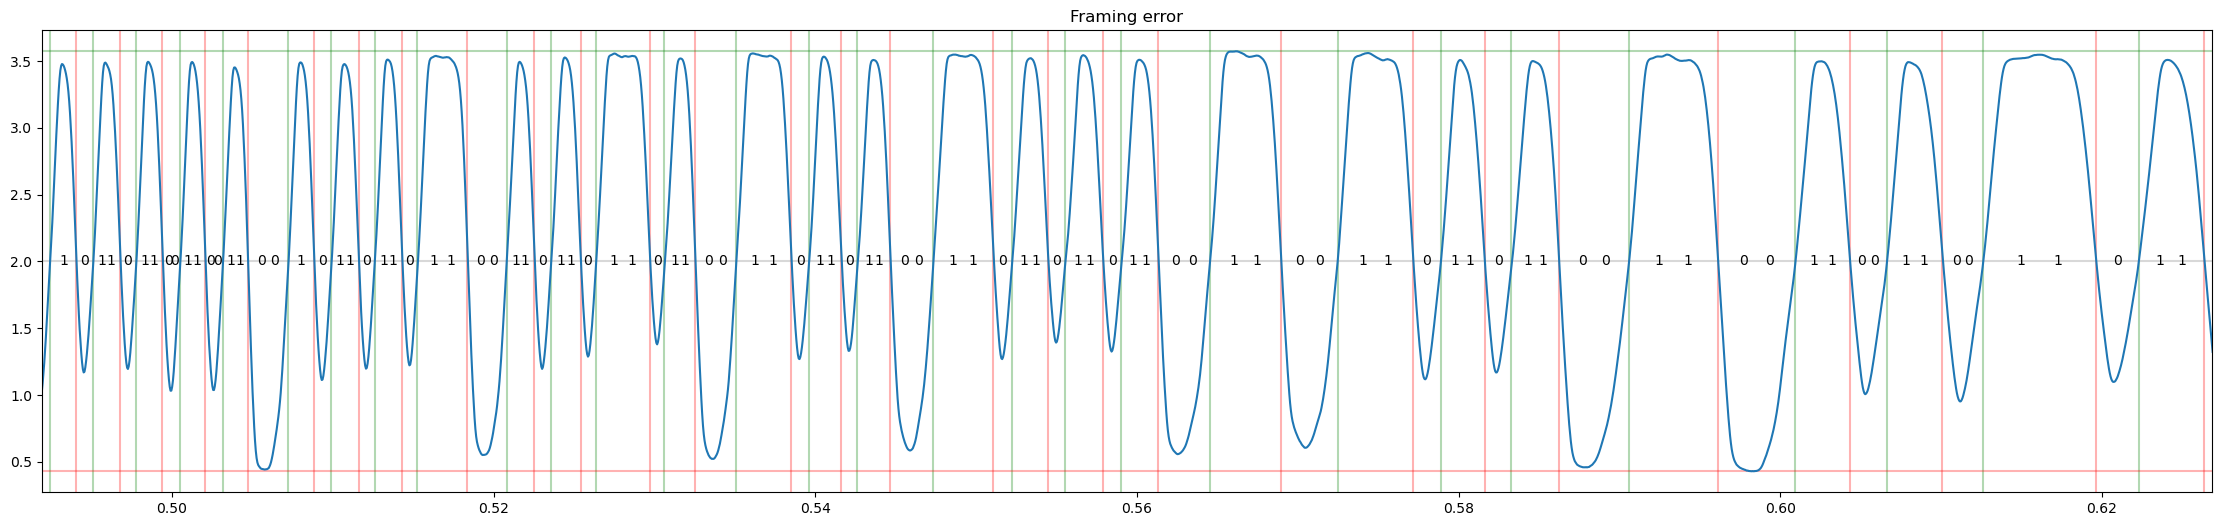

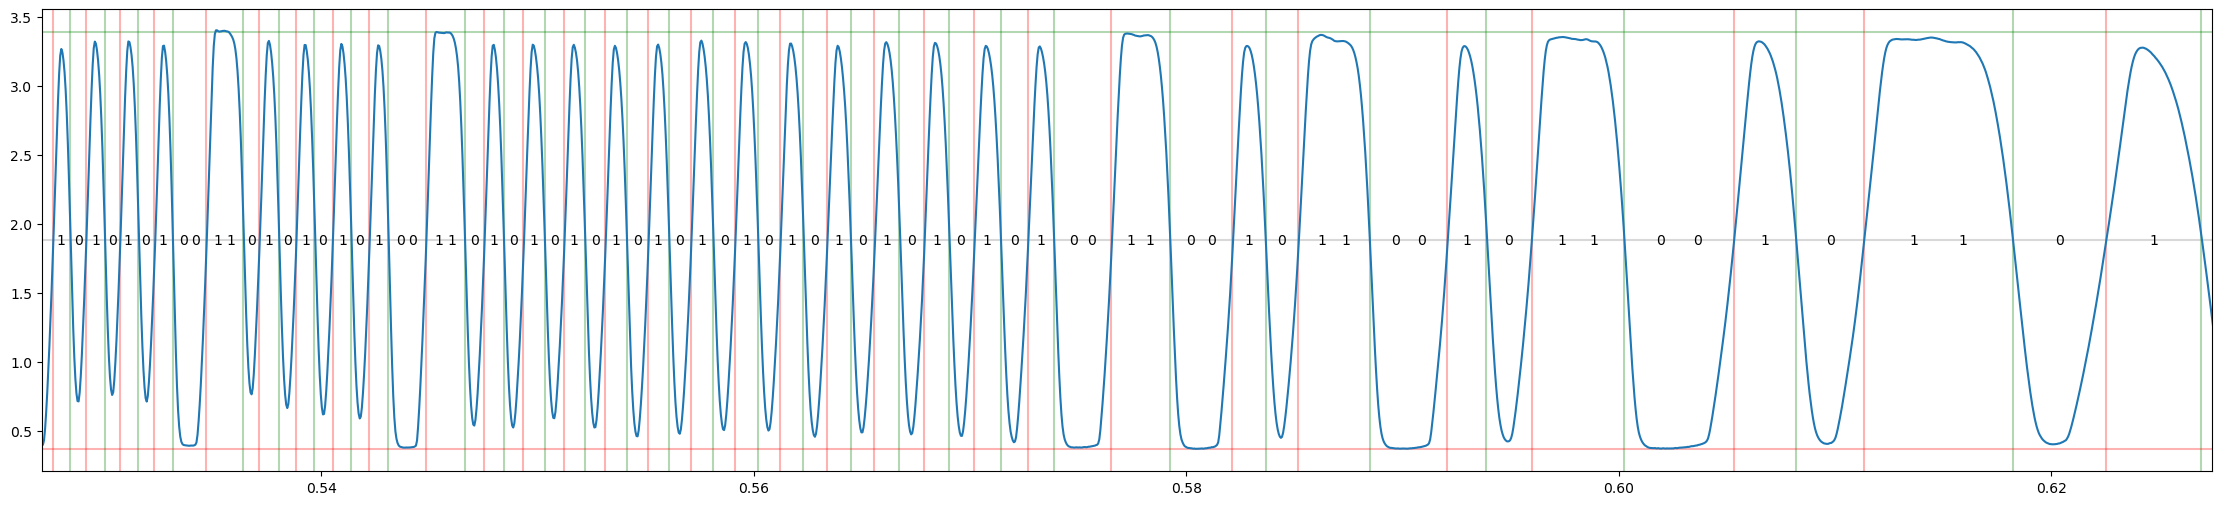

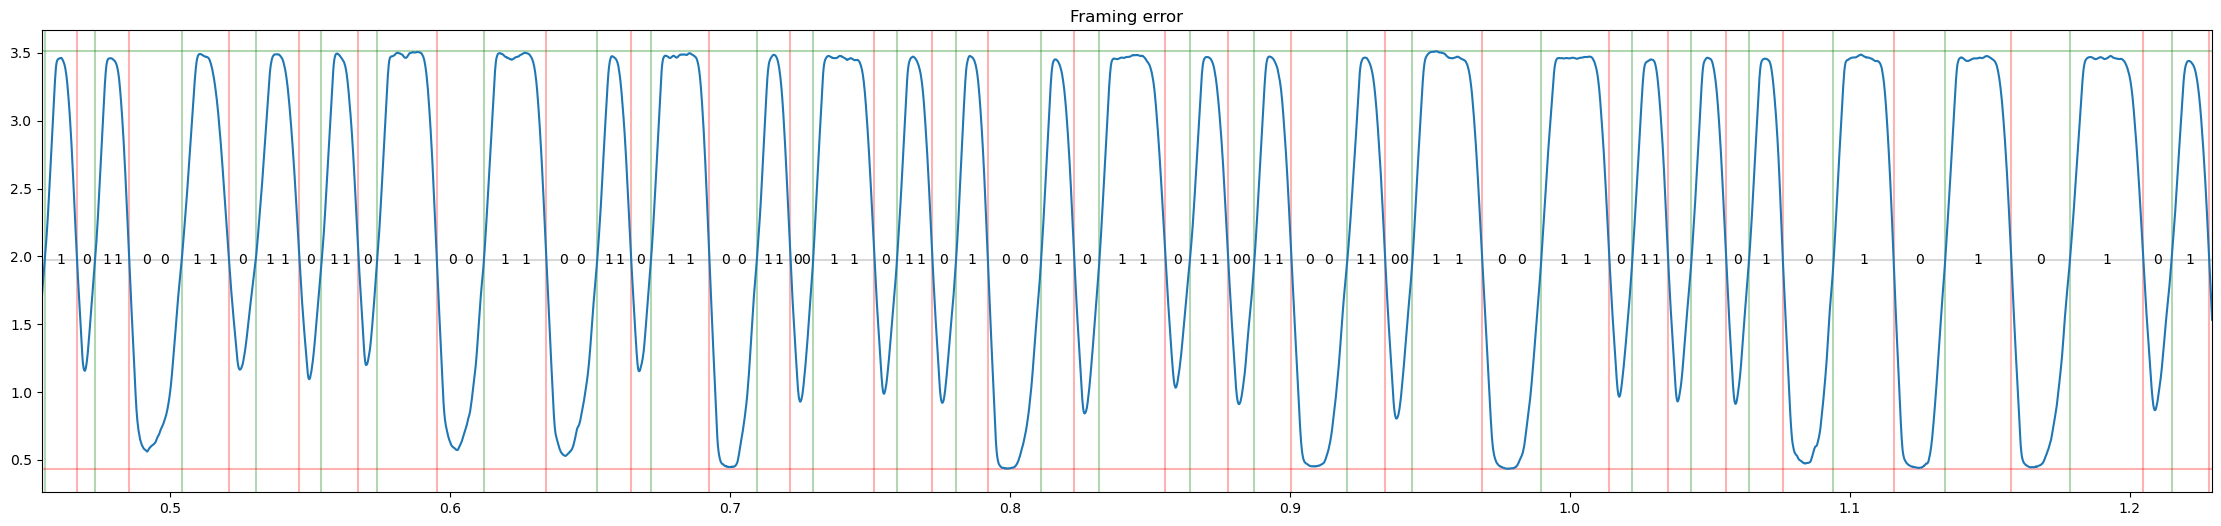

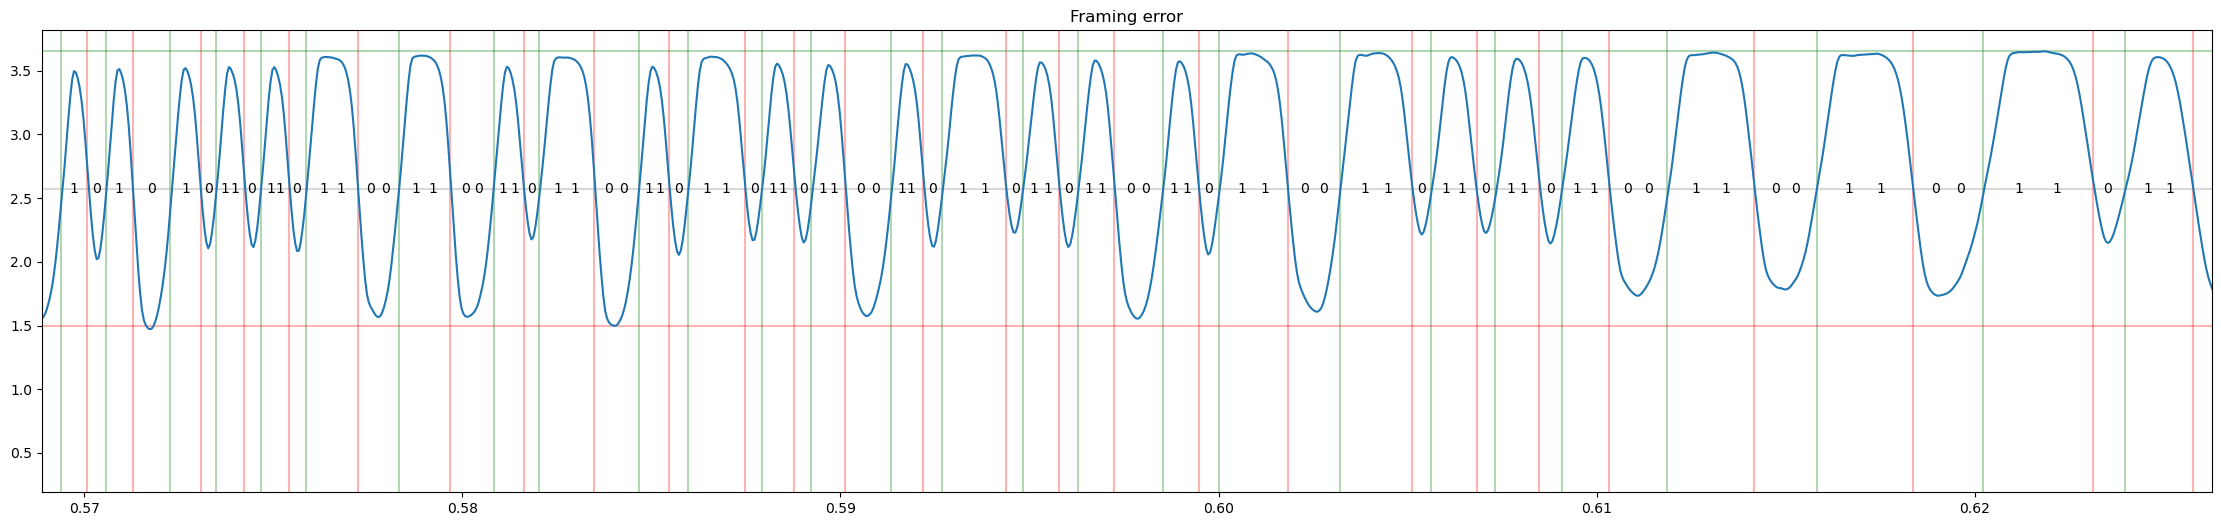

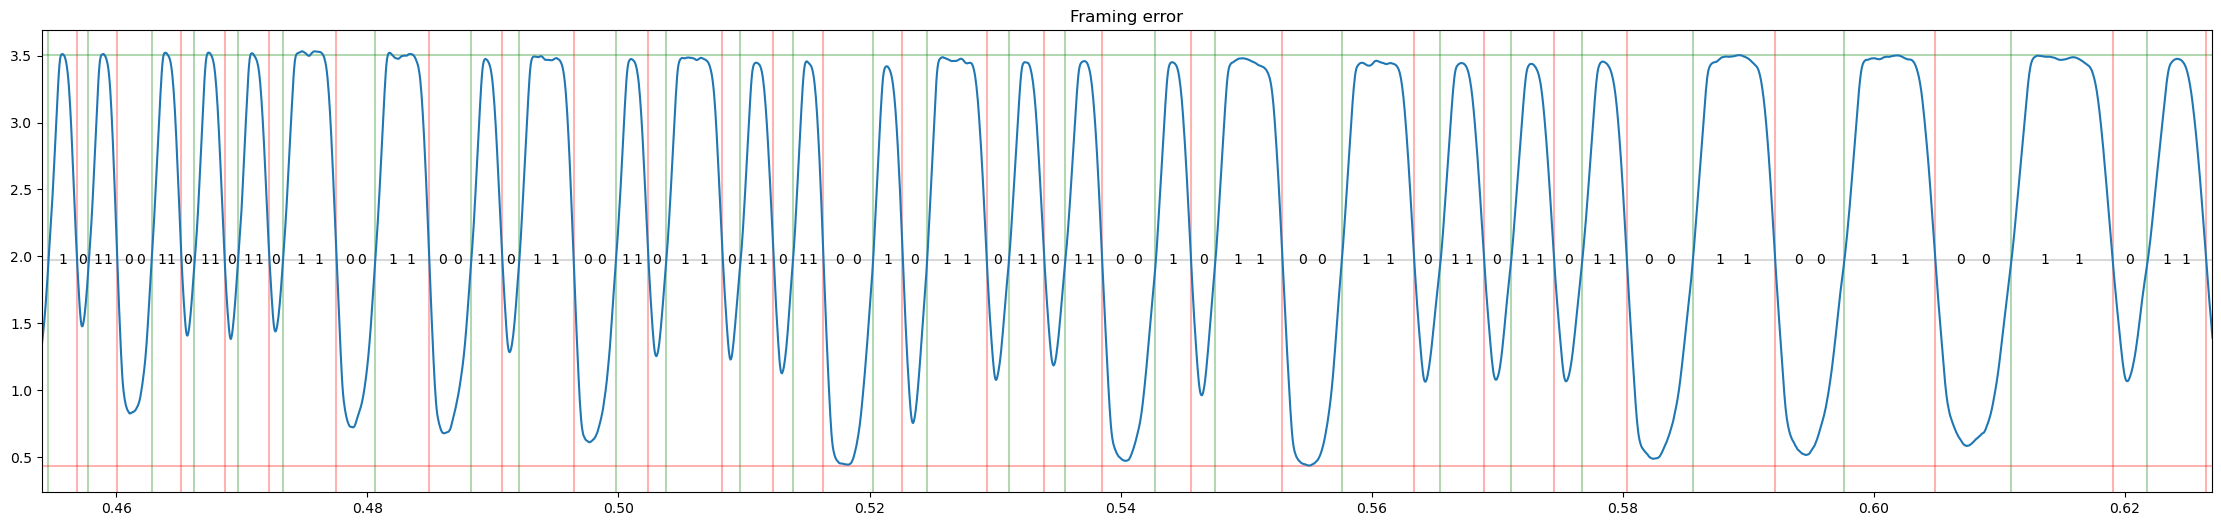

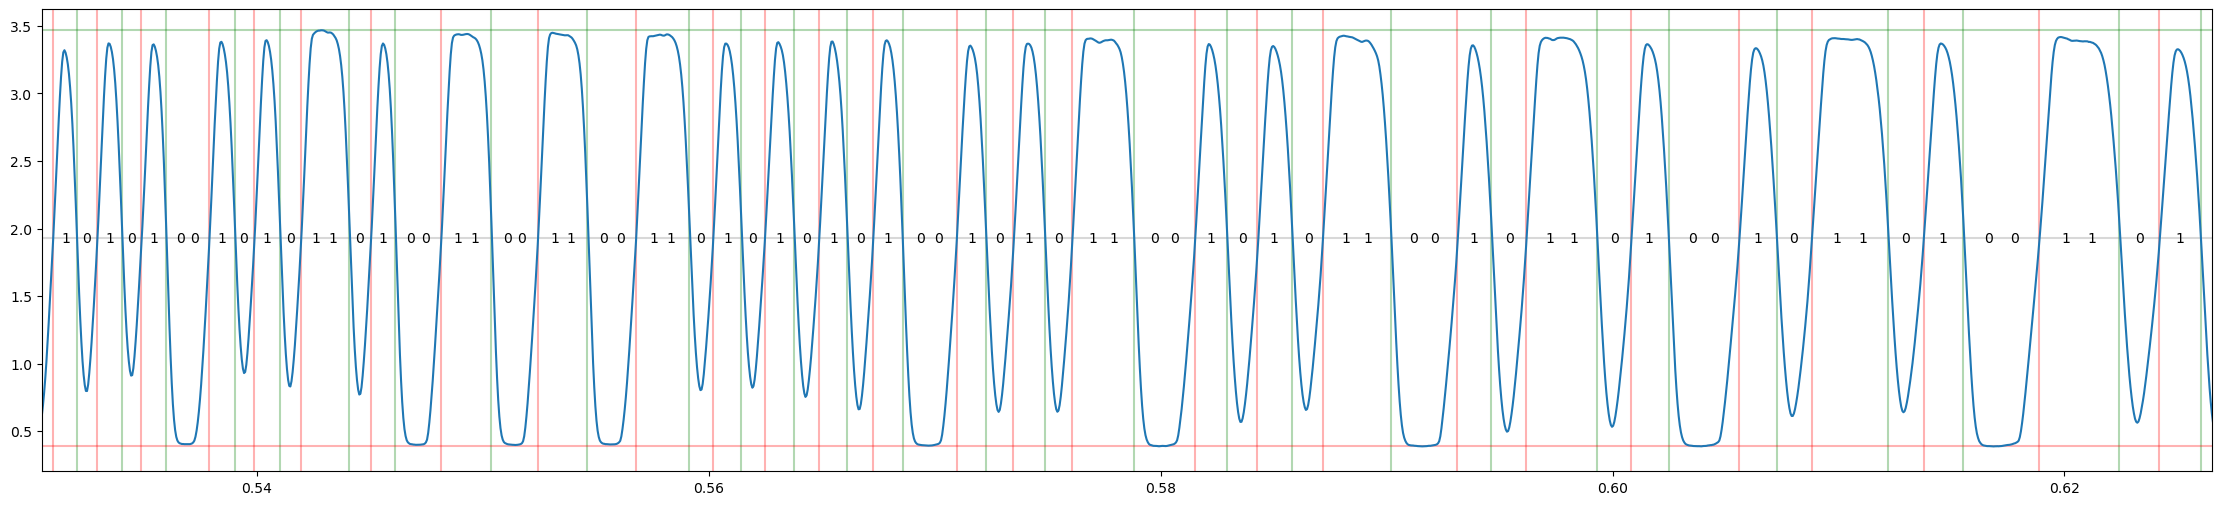

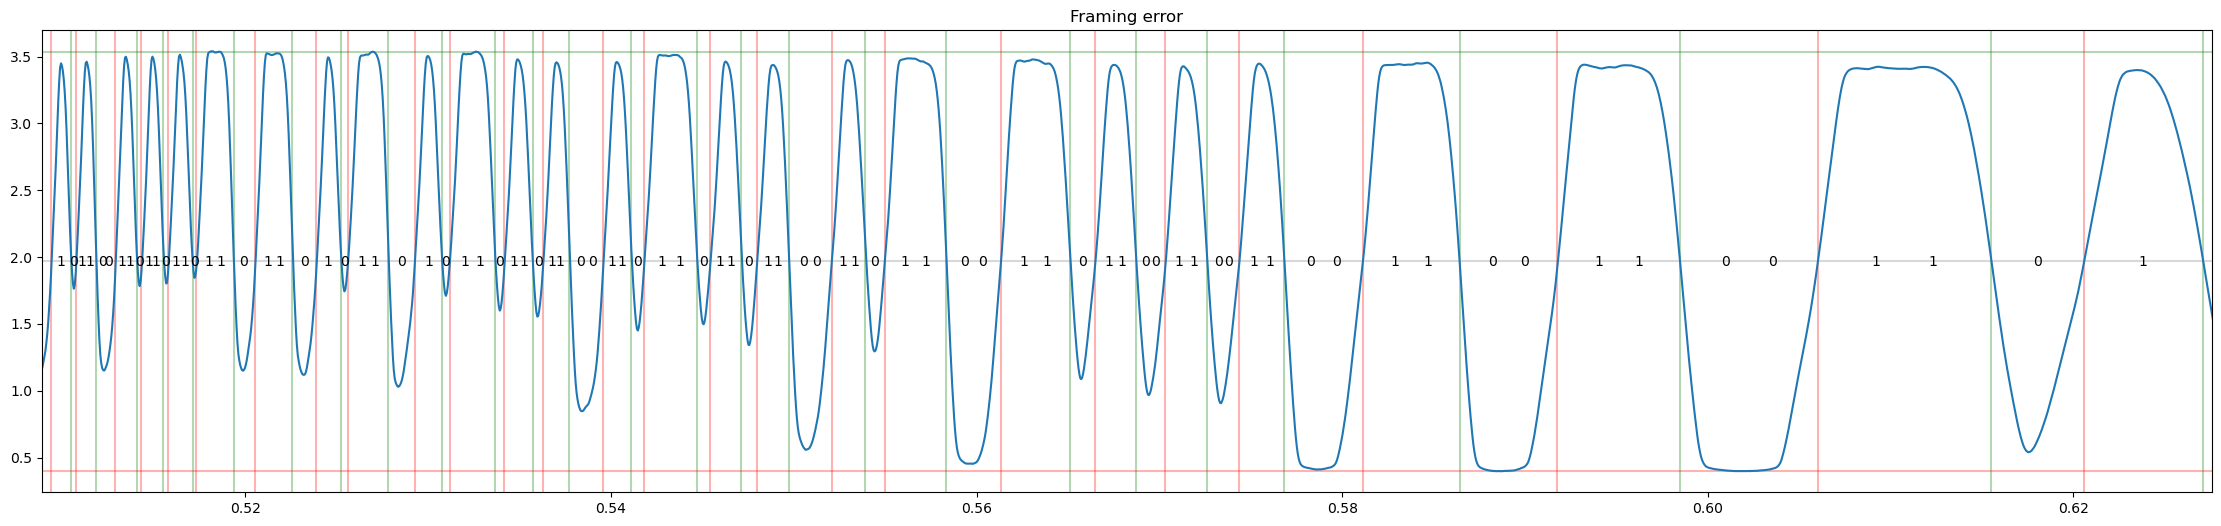

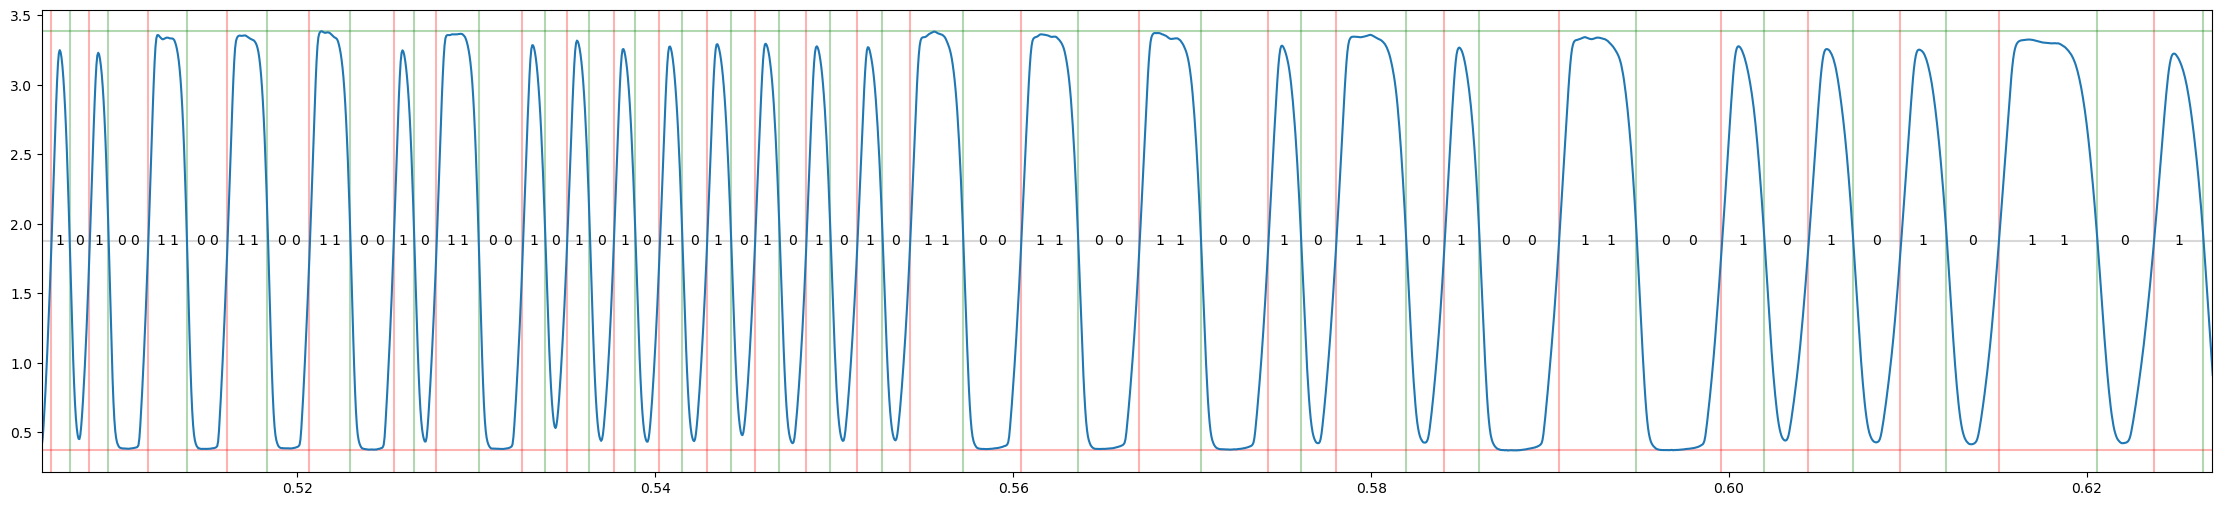

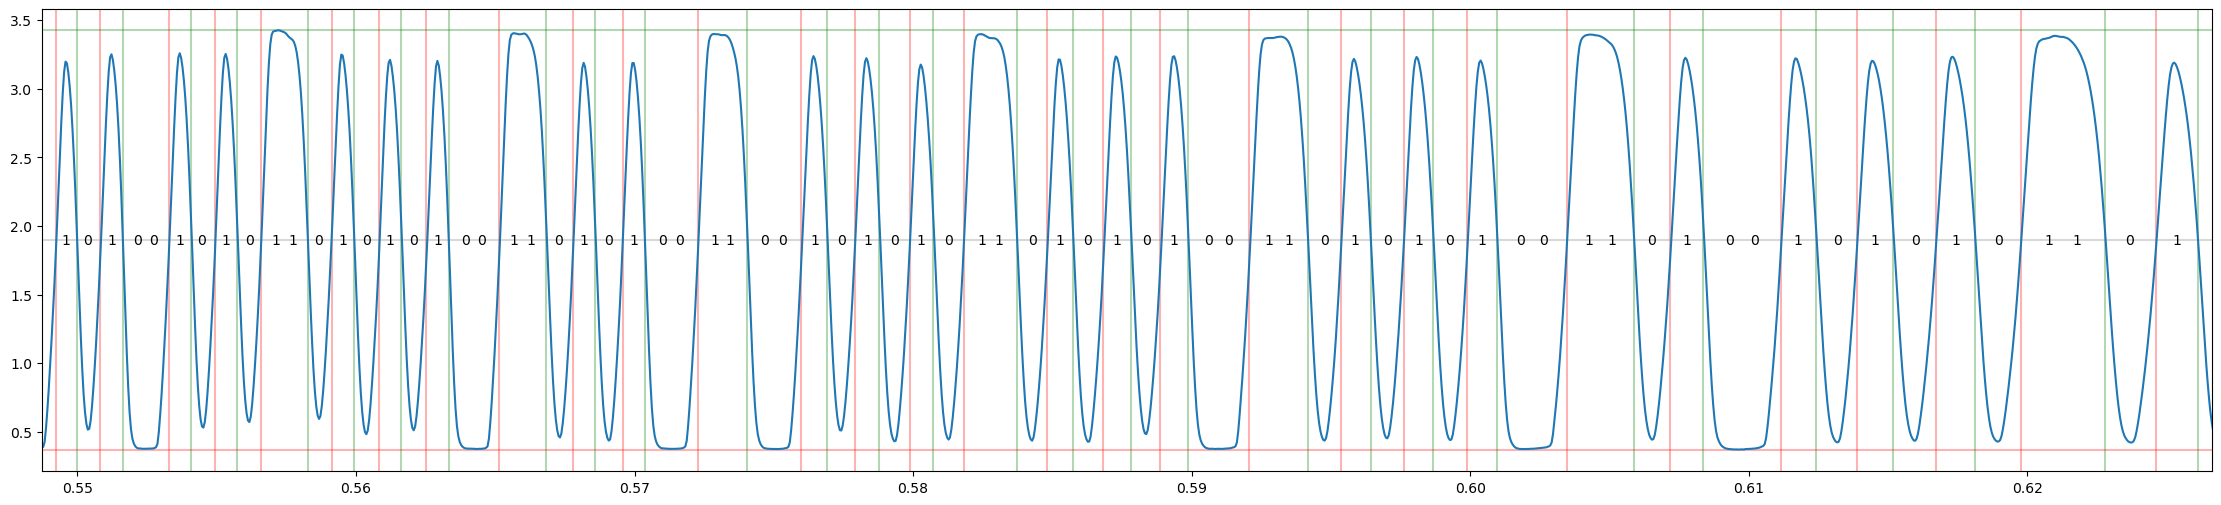

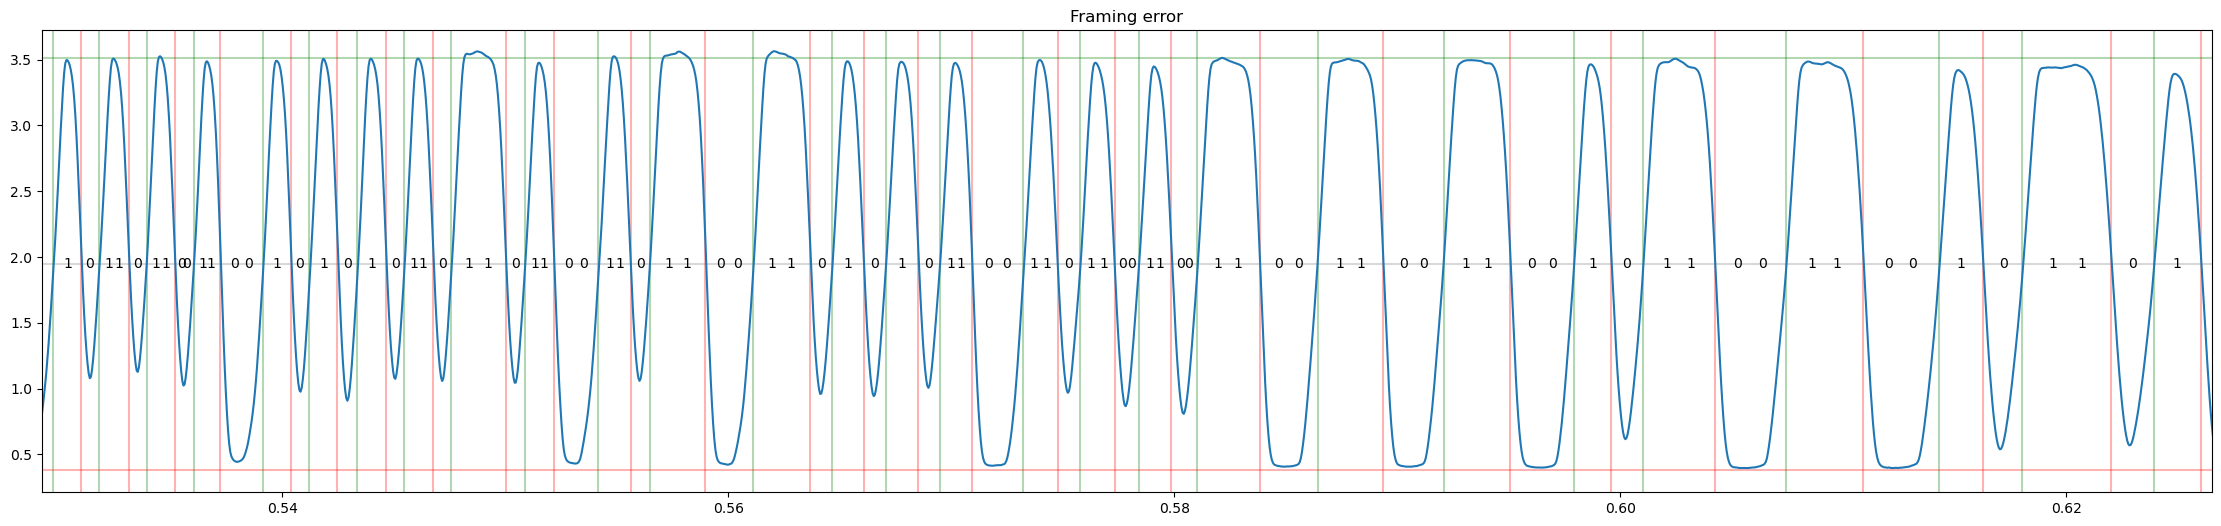

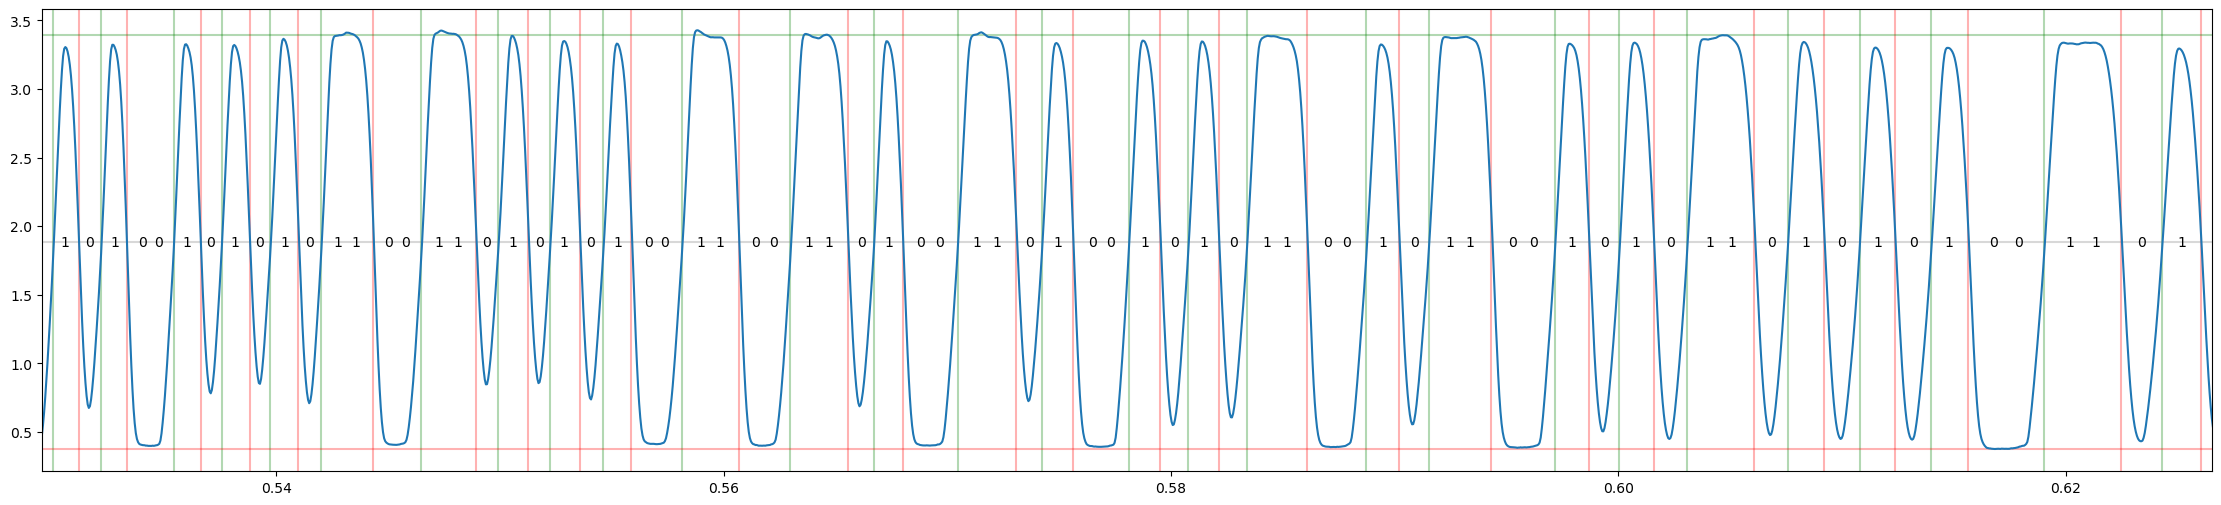

In [42]:
def decode_bits(ax, data, times, found):
    found_a, found_b = found
    d, t = data[found_a:found_b], times[found_a:found_b]
    ax.plot(t, d)
    ax.set_xlim([t[0], t[-1]])

    subslice = d[len(d)//2 - len(d)//6:len(d)//2 + len(d)//6]
    low, high = subslice.min(), subslice.max()
    amp = high - low
    # use slightly more than one half to account for the fact that we don't quite go dark during narrow black lines due to our detector's slit width
    th = low + amp*0.5
    ax.axhline(low, color='red', alpha=0.3, zorder=-3)
    ax.axhline(high, color='green', alpha=0.3, zorder=-3)
    ax.axhline(th, color='gray', alpha=0.3, zorder=-3)

    bits = (d > th).astype(int)
    edges = np.argwhere(bits[1:] - bits[:-1])[:,0]

    print('adjusting edges', end=' ')
    new_edges = np.copy(edges)
    # for i, (left, mid, right) in enumerate(zip(edges[0:], edges[1:], edges[2:])):
    #     new_value = i%2

    #     if new_value:
    #         min_v, max_v = d[left:mid].min(), d[mid:right].max()
    #     else:
    #         max_v, min_v = d[left:mid].max(), d[mid:right].min()

    #     local_th = min_v + (max_v - min_v)/2
    #     ax.plot(t[mid], local_th, marker='+', color='gray')
    #     local_v = d[mid] > local_th
    #     if local_v and new_value:
    #         for j in range(mid, left, -1):
    #             if d[j] <= local_th:
    #                 break
    #     elif local_v and not new_value:
    #         for j in range(mid, right):
    #             if d[j] <= local_th:
    #                 break
    #     elif not local_v and new_value:
    #         for j in range(mid, right):
    #             if d[j] >= local_th:
    #                 break
    #     elif not local_v and not new_value:
    #         for j in range(mid, left, -1):
    #             if d[j] >= local_th:
    #                 break
    #     print(j-new_edges[i+1], end=' ')
    #     new_edges[i+1] = j

    edges = new_edges
    
    for i, x in enumerate(edges):
        new_value = not i%2
        ax.axvline(t[x], color=('green' if new_value else 'red'), alpha=0.3, zorder=-5)

    intervals = edges[1:] - edges[:-1]

    mean_ref = intervals[len(intervals)//2 - len(intervals)//6:len(intervals)//2 + len(intervals)//6].mean()
    
    for i, x in enumerate(intervals):
        if 0.1 < x/mean_ref < 10:
            break
    intervals = intervals[i:]
    edges = edges[i:]

    for i, x in enumerate(intervals[::-1]):
        if 0.1 < x/mean_ref < 10:
            break
    if i>0:
        intervals = intervals[:-i]
        edges = edges[:-i]

    ax.set_xlim([t[edges[0]-10], t[edges[-1]+10]])

    last_val = 1
    bits = [1]
    text = lambda i, x, bit: ax.text(t[round(edges[i] + x)], th, str(bit), verticalalignment='center', horizontalalignment='center')
    text(0, intervals[0]/2, 1)
    for i, (ivl_left, ivl_right) in enumerate(zip(intervals[:-1], intervals[1:])):
        bit_right = i%2
        if last_val == 1:
            if ivl_right / ivl_left > 1.5:
                last_val = 2
                bits.append(bit_right)
                bits.append(bit_right)
                text(i+1, ivl_right/3, bit_right)
                text(i+1, ivl_right/3*2, bit_right)
            else:
                last_val = 1
                bits.append(bit_right)
                text(i+1, ivl_right/2, bit_right)
        else: # last_val == 2
            if ivl_left / ivl_right > 1.5:
                last_val = 1
                bits.append(bit_right)
                text(i+1, ivl_right/2, bit_right)
            else:
                last_val = 2
                bits.append(bit_right)
                bits.append(bit_right)
                text(i+1, ivl_right/3, bit_right)
                text(i+1, ivl_right/3*2, bit_right)
    bits = np.array(bits)
    bits_out = np.copy(bits)

    if (bits[:4] == [1, 0, 1, 0]).all() and (bits[-5:] == [0, 1, 1, 0, 1]).all() and len(bits) == (64 + 4 + 5):
        bits_rm = bits[4:-5]
        print(f'Edges ok, found {len(bits_rm)} manchester bits')
        db = bits_rm[0::2] - bits_rm[1::2]
        err = np.argwhere(db == 0)
        if err.any():
            print(f'Manchester errors at {indices[:,0]}')
        bits = (db + 1)//2
        print(f'Resulting payload length: {len(bits)} bits')
        print('Payload:', ''.join(map(str, bits)))

        rm = ReedMuller(3, 5)
        #bits = [int(bool(0x1234567&(2**i))) for i in range(26)]
        #bits = rm.encode(bits)
        decoded = rm.decode(bits)
        d_out = sum(2**i for i, x in enumerate(decoded) if x)
        print(f'Resuling data word: {d_out:07x}')
    else:
        print('Framing error')
        ax.set_title('Framing error')

    return bits_out

found_bits = []
for (td, times, data), found in zip(wfs, found_signals):
    fig, ax = plt.subplots(figsize=(28, 6))
    bits = decode_bits(ax, data, times, found)
    bits_s = ''.join(map(str, bits))
    print(bits_s)
    print()
    found_bits.append(bits)
#bits_ref = '1010010101011001100101100101101010010110101001011001101010100110011001101'
#print(bits_ref)
#print(''.join('.' if x == ref else '#' for x, ref in zip(bits_s, bits_ref)))

Found 116 transitions


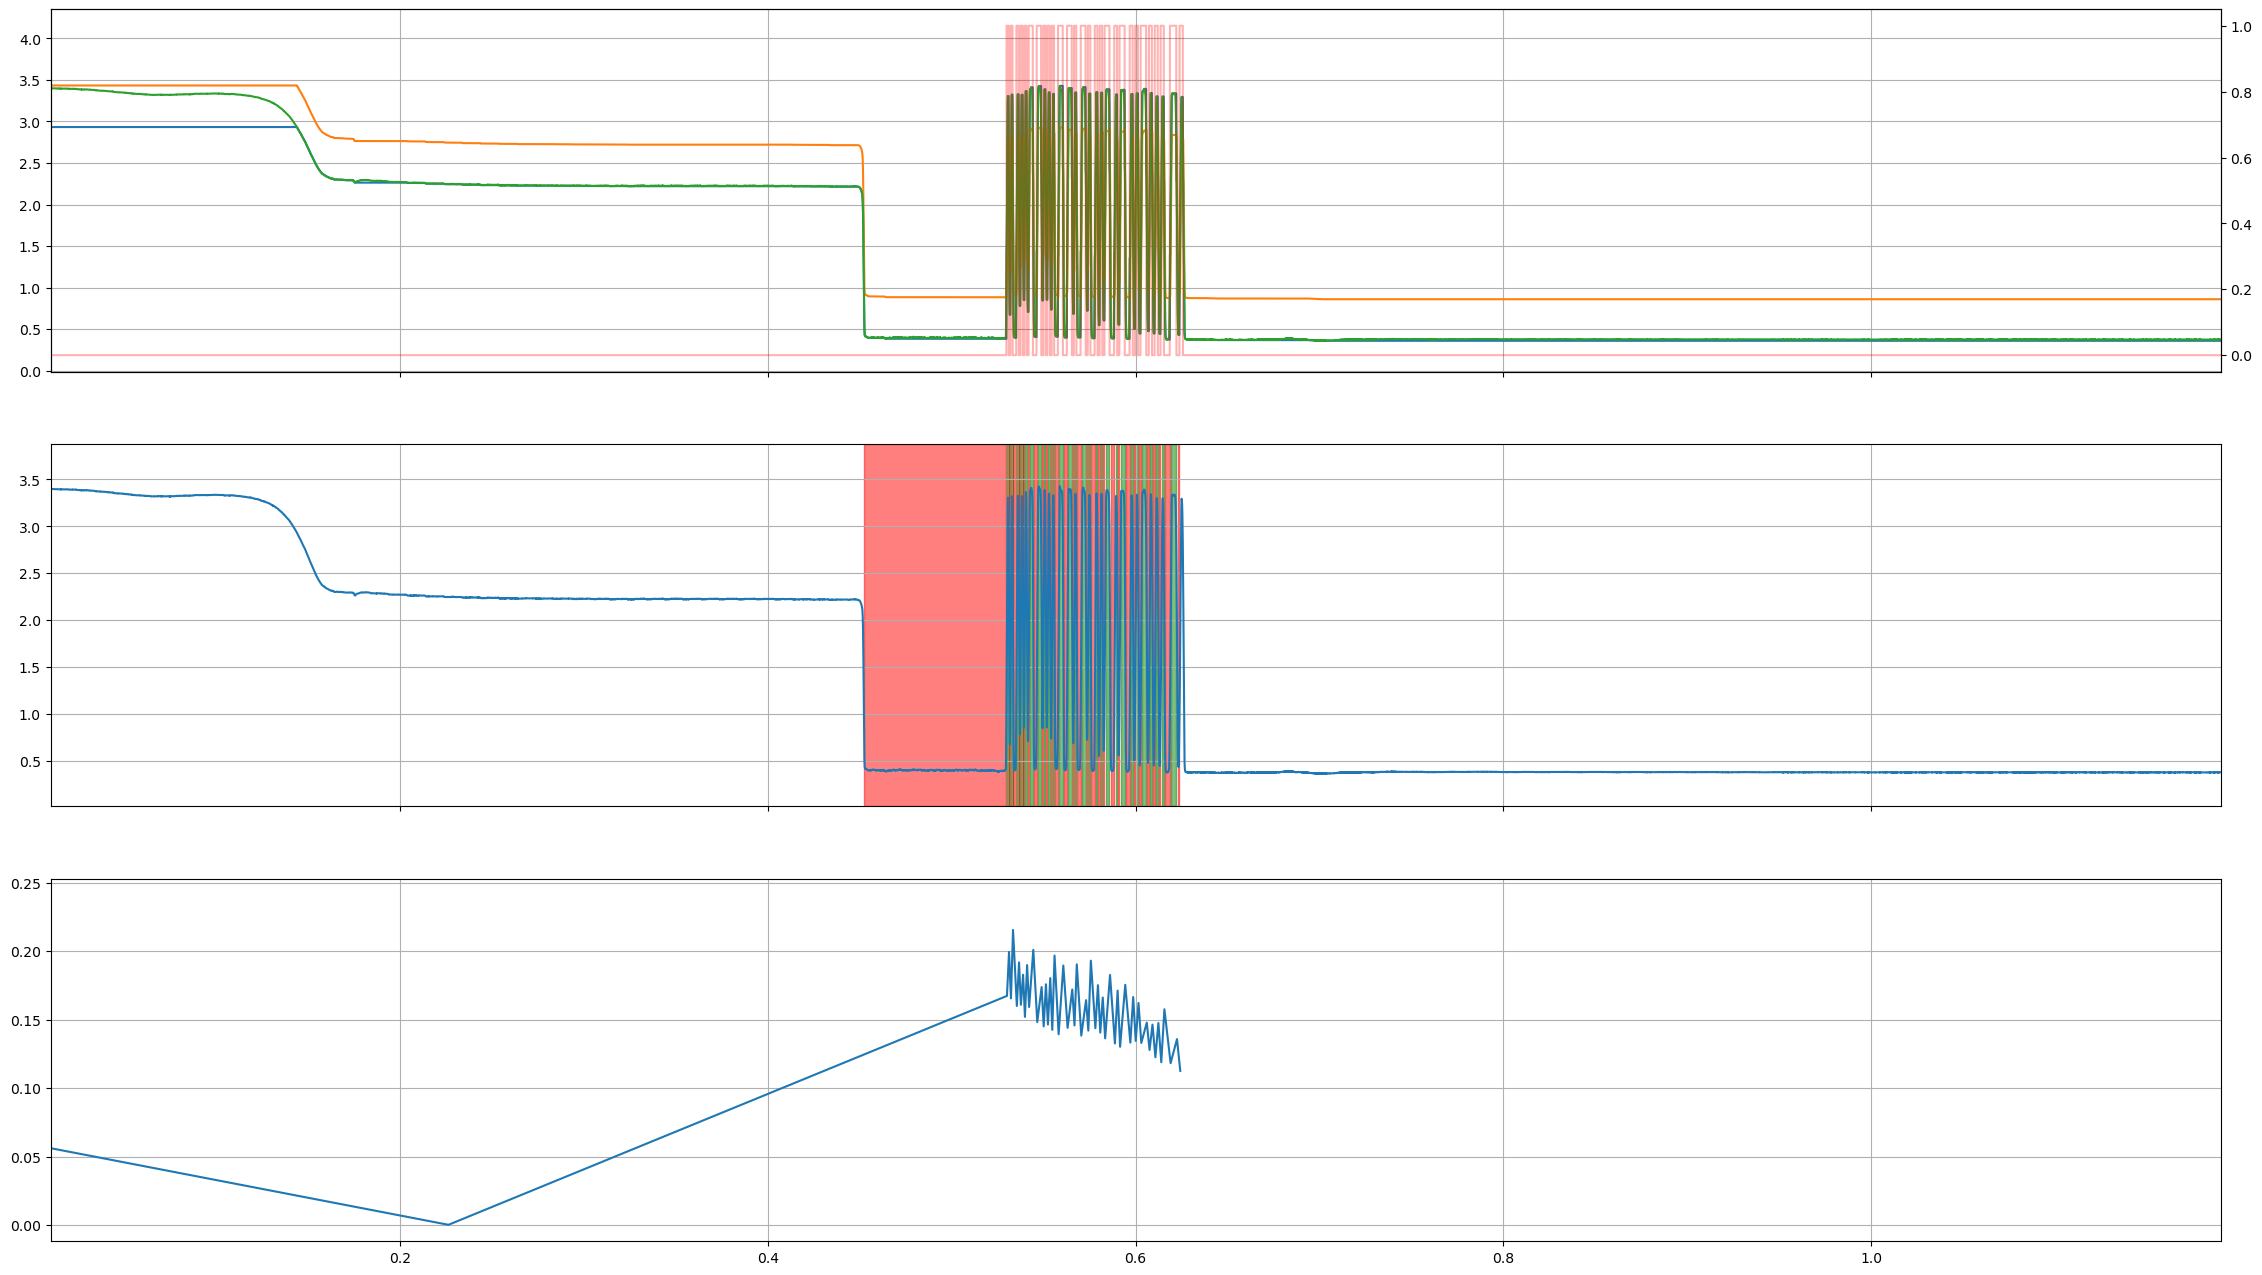

In [6]:
th = 0.5

outval = []
vrefout = []
vthout = []
start = 0
val = False
timestamps = []
vref = data[0] + th
mins, maxs = [], []
for i, v in enumerate(data):
    if abs(vref - v) > th and ((v > vref and not val) or (v < vref and val)):
            for j in range(i-1, start, -1):
                d = data[j] - vref
                if val and d < -th or not val and d > th:
                    timestamps.append((j+1, val))
                    break
            timestamps.append((i, None))
            start = i

            if val:
                maxs.append(vref)
            else:
                mins.append(vref)
                
            vref = (v - .9*th) if val else (v + .9*th)
            val = not val
    elif val and v > vref:
        vref = v
    elif not val and v < vref:
        vref = v
    outval.append(val)
    vrefout.append(vref)
    vthout.append((vref - th) if val else (vref + th))

timestamps = timestamps[1:-1]
print(f'Found {len(timestamps)} transitions')
#for ts, val in timestamps:
#    print(ts, val)

fig, axs = plt.subplots(3, 1, figsize=(28, 16), sharex=True)
ax = axs[0]
ax.twinx().plot(times, np.array(outval).astype(int), color='red', alpha=0.3)
ax.plot(times, vrefout)
ax.plot(times, vthout)
ax.plot(times, data)
ax.grid()

ax = axs[1]
for (prev_ts, prev_val), (next_ts, next_val) in zip(timestamps[:-1], timestamps[1:]):
    if prev_val is not None:
        col = 'green' if prev_val else 'red'
        ax.axvspan(times[prev_ts], times[(next_ts-1)], color=col, alpha=0.5)
ax.plot(times, data)
ax.set_xlim([times[200], times[-200]])
ax.grid()
ax = axs[2]
slopes = []
slope_times = []
bar_widths = []
bar_vals = []
slope_widths = []
for (prev_ts, prev_val), (next_ts, next_val) in zip(timestamps[:-1], timestamps[1:]):
    #print(prev_ts, prev_val, next_ts, next_val)
    td = next_ts - prev_ts
        
    if prev_val is None:
        vd = abs(data[next_ts] - data[prev_ts])
        slope_times.append((times[prev_ts] + times[next_ts])/2)
        if td > 0:
            slopes.append(vd/td)
            #slopes.append(1/td)
        else:
            slopes.append(abs(data[prev_ts-1] - data[prev_ts+1])/2)
        slope_widths.append(td)
        
    else:
        bar_widths.append(td)
        bar_vals.append(prev_val)

slope_widths[-1] = slope_widths[-2] # compensate for last slope usually being way long
ax.plot(slope_times, slopes)
ax.grid()
#ax.set_xlim([slope_times[0], slope_times[-1]])
#ax.set_xlim([slope_times[0] - .02, slope_times[-1] + .02])
#ax.set_xlim([times_sel[-1300], times_sel[-700]])
#ax.set_xlim([slope_times[0], slope_times[0]+(slope_times[1]-slope_times[0])*5])
#ax.set_xlim([0.05, 0.15])